# This notebook 
#### 1. Get the time series from the selected lakes
#### 2. Get data from selected lakes
#####    - Lake shapefile, area
#####    - Lake ice
#### 3. Preprocess ground observation of the selected lakes individually
#### 4. Save dataframe will all the time series preprocessed 
#### 5. Preprocess altis data of the selected lakes 
#### 6. Generate the matching time series of ground and altimeter observations

# Libraries to import 

In [2]:
from ground_data import GroundObservations
from ts_preprocesing import *#get_date_time_cols, convert_units and all the functions 
from ts_plots import *

import geopandas as gpd
import platform
import scipy.interpolate as sc
import geopandas as gpd
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pytz

from timezonefinder import TimezoneFinder
from pytz import timezone
import timeit
from datetime import datetime
from icecream import ic

utc=pytz.utc
utc.zone
%reload_ext autoreload
%autoreload 2

# 1. Get the time series from the selected lakes
###  Getting locss stations

In [5]:
# Getting locss stations

go=GroundObservations()
height_fd='height'

lc_lakes=['KHB2','HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','MAB2', 'CQK2', 'SKT2', 'MCW2', 'PAW2', 'MRP2', 'SPA2', 'BLB2','RLH2','MTN2', 'VCN2', 'FDN2']

####NOTE
#VNC2 is the other gauge in Mattamuskeet 
#FDN2 is the other gauge in Phelps


#Read only data from the lakes with the codes specified in lc_lakes
df_locss=go.read_ground_data('LOCSS', station_id=lc_lakes)
df_locss=get_date_time_cols(df_locss, 'date', has_hour=True) #Expand date details in coloumns
stations=df_locss['gauge_id'].unique()

#Unify all the units to the metric system
df_final=convert_units(df_locss,height_fd, origin='FEET', to='METER', unit_fd='unit',
                  gauge_fd='gauge_id')

#Extract gauges that are not operational less than 2 data
lk_id_fd='gauge_id'

df_readings_count=df_final.groupby([lk_id_fd], as_index=False).size()
no_operational_gauges=df_readings_count.loc[df_readings_count['size']<=2][lk_id_fd]


df_final=df_final.loc[~df_final[lk_id_fd].isin(no_operational_gauges)]
print('Initial size',df_final.shape)

#Calculate the differences between consecutive values and dates
#Remove and process duplicate dates

cut_off=0.05 #cut_off for the standard deviation

gauges_list=lc_lakes#df_final[st_id].unique()

date_fd='date'
cols=['gauge_id', 'name', 'date', 'time', 
       'min_height', 'max_height', 'unit', 'source',
       'year', 'month', 'day', 'hour', 'decimal_y']

#use help to see the desciption of filter_extreme_duplicates. i.e., help(filter_extreme_duplicates)         
df_final_nd, df_final_removed, discarded, n_duplicated=filter_extreme_duplicates(df_final, lk_id_fd, date_fd,height_fd, cols, cut_off, gauge_list=gauges_list, exact_date=False)

#Total values outside the cut off. These were filtered out
print("Total values outside cut off: "+str(discarded)+"\n")#df_final_removed[['gauge_id', 'height_count', 'date', 'time', 'height_std']])
print("Total duplicated values: "+str(n_duplicated))
# print("Gauges with values in the same date: \n", df_final_nd.gauge_id.unique())

# df_final_nd.gauge_id.unique()
# gauges_list
df_final_nd.rename(columns={'height_rc':height_fd}, inplace=True)
# df_final_nd
# #Extract the ones with duplicates from df_final
df_temp=df_final.loc[~df_final[lk_id_fd].isin(df_final_nd[lk_id_fd].unique())]
df_temp
df_temp=pd.concat((df_temp, df_final_nd), axis=0)
print('Final size',df_temp.shape)
#Total save data for suplememntal material 

df_temp.loc[~(df_temp['height_count'].isnull())&(df_temp['height_count']>=2)].to_csv('../data/for_paper/sumary_LOCSS_same_date.csv')
df_final_removed.to_csv('../data/for_paper/LOCSS_removed_cut_off.csv')

Initial size (4006, 18)
Total values outside cut off: 1

Total duplicated values: 35
Final size (3969, 20)


# 1. Get the time series from the selected lakes
### Getting ARHN stations from file
### Getting USGS stations from file. Still working on R script connection to get them from USGS
### Getting Brazilian Reservoirs from file

In [4]:
# Getting ARHN stations 

# #'2102' Is a meteorlogical station 
ar_lakes=['1824', '2830', '1830','2832', '2028','2231','2234','2300','2316']#'1805', '1819',
skip_rows=1

df_arhn=go.read_ground_data('ARHN', skip_rows=skip_rows, station_id=ar_lakes)
df_arhn=get_date_time_cols(df_arhn, 'date', has_hour=True)

# Getting USGS stations from file. Still working on R script connection
us_lakes=['2464800','6903880','6604000']
df_usgs=go.read_ground_data('USGS',station_id=us_lakes)
df_usgs=get_date_time_cols(df_usgs, 'date')
df_usgs=convert_units(df_usgs,height_fd, origin='FEET', to='METER', 
                  gauge_fd='gauge_id')

# Getting Brazilian Reservoirs
rvbr_lakes=['19069','19060','19126', '12030', '12036', '12327','12056']
df_rvbr=go.read_ground_data('RVBR', station_id=rvbr_lakes)
df_rvbr=get_date_time_cols(df_rvbr,'date')

#### Concat all the ground observations in a single dataframe

In [329]:
#Relevant columns
# df_ground_ts=pd.DataFrame()
common_cols=['gauge_id','source','decimal_y','height','date','year', 'month', 'day', 'hour']
# df_usgs[common_cols]
df_ground_ts=pd.concat((df_usgs[common_cols].copy(),df_arhn[common_cols].copy(), df_temp[common_cols].copy(), df_rvbr[common_cols].copy()), axis=0)

# df_ground_ts=df_temp[common_cols].copy()
df_ground_ts['doy']=df_ground_ts['date'].dt.dayofyear
df_ground_ts.shape
# pd.datetime(+pd.to_datetime(df_final['time'], format='%H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
# df_ground_ts.columns

(362785, 10)

# 2. Get data from selected lakes
###   - Lake shapefile, area, lake name
###   - Lake ice
###  Generate the file with all the initial preprocesing 

In [330]:
#Get all lakes 
if platform.system()=='Linux':
    path_lakes='/home/angelica/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'#wgs84_f.shp'
else:
    path_lakes='C:/Users/amgomez/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'#wgs84_f.shp'

df_sel_lakes=gpd.read_file(path_lakes)

#Read all the gauges with time series to process. This file contain the lake ids that will be used in the computated. It is used to filter the shapefile dataframe
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


if platform.system()=='Linux':
    altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
else:
    altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  

selected_lakes=altis_csv['lake_id'].dropna().unique()
selected_lakes=[str(int(x)) for x in selected_lakes]
#merge name based on gauge_id
df_lake_name=df_sel_lakes.loc[df_sel_lakes['lake_id'].isin(selected_lakes), ['gauge_id','lake_name', 'lake_id']]

# Manually add gauge ids of lakes that have more than one gauge and did not have gauge id
temp_2gauge=df_lake_name.loc[(df_lake_name['gauge_id']=='PHN2')|(df_lake_name['gauge_id']=='MTN2')].copy()
temp_2gauge['gauge_id']=None
df_lake_name=pd.concat([df_lake_name,temp_2gauge])

for index,x in df_lake_name.loc[df_lake_name['gauge_id'].isna()].iterrows():
    lkid=x['lake_id']
    gauge_id=altis_csv.loc[altis_csv['lake_id']==int(lkid), 'station_id'].values[0]
    df_lake_name.loc[df_lake_name['lake_id']==lkid, 'gauge_id']=gauge_id

df_ground_ts=pd.merge(df_ground_ts, df_lake_name, on='gauge_id',how='left')

In [331]:
#Section discarted 
#Add the ice covered from Xiao's code

# df_ice=pd.read_csv('../data/locss_ice.csv')
# df_ice
# df_ice=pd.merge(df_ice, df_sel_lakes[['Hylak_id', 'gauge_id']], on='Hylak_id', how='left')
# df_ground_ts=pd.merge(df_ground_ts, df_ice[['Hylak_id', 'gauge_id','SLIDE_snowIce','doy']], on=['gauge_id','doy'], how='left')
# df_ground_ts.to_csv('../data/temp_sample_LOCSS_data.csv')


# 3. Preprocess ground observation of the selected lakes individually

In [332]:
# first, create a copy just in case
df_ground_ts_org=df_ground_ts.copy()

In [333]:
# df_ground_ts=df_ground_ts_org.copy()


In [334]:
#Function to plot before and after 
def plot_ts_preproc(df_before, df_after, st_id, date_fd, height_fd, labels):
    title=labels['title']['label']
    title_s=labels['title']['size']
    x_label=labels['x']['label']
    y_label=labels['y']['label']
    xl_font_size=labels['x']['font_lbl_s']
    x_interval=labels['x']['freq_interval']
    yl_font_size=labels['y']['font_lbl_s']
    xl_tick_size=labels['x']['tick_s']
    yl_tick_size=labels['y']['tick_s']
    
    df1=df_before
    df1=df1.sort_values(by=date_fd)
    fig1, ax= plt.subplots(figsize=(20, 6))
    plt.plot(df1[date_fd], df1[height_fd], linewidth=5)
    plt.title(st_id+' before'+title, fontsize=title_s)

    ax.set_xlabel(x_label, fontsize=xl_font_size)
    ax.set_ylabel(y_label,fontsize=yl_font_size)
    ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
    
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    plt.xticks(fontsize=xl_tick_size)
    plt.gcf().autofmt_xdate()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.subplots_adjust(bottom=0.15)
    
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    
    
    df1=df_after
    df1=df1.sort_values(by=date_fd)
    fig2, ax=plt.subplots(figsize=(20, 6))
    plt.plot(df1[date_fd], df1[height_fd], linewidth=5)
    plt.title(st_id+' after'+ title, fontsize=title_s)
    ax.set_xlabel(x_label, fontsize=xl_font_size)
    ax.set_ylabel(y_label,fontsize=yl_font_size)
    ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
    
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    plt.xticks(fontsize=xl_tick_size)
    plt.gcf().autofmt_xdate()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.subplots_adjust(bottom=0.15)
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    return fig1, fig2
    

### Extract and move reference point of the stations KHB2
#### Reason: The gauge is moved during the monitoring, the reference point moves as well


/tmp/ipykernel_519712/2766265906.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
/tmp/ipykernel_519712/2766265906.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)


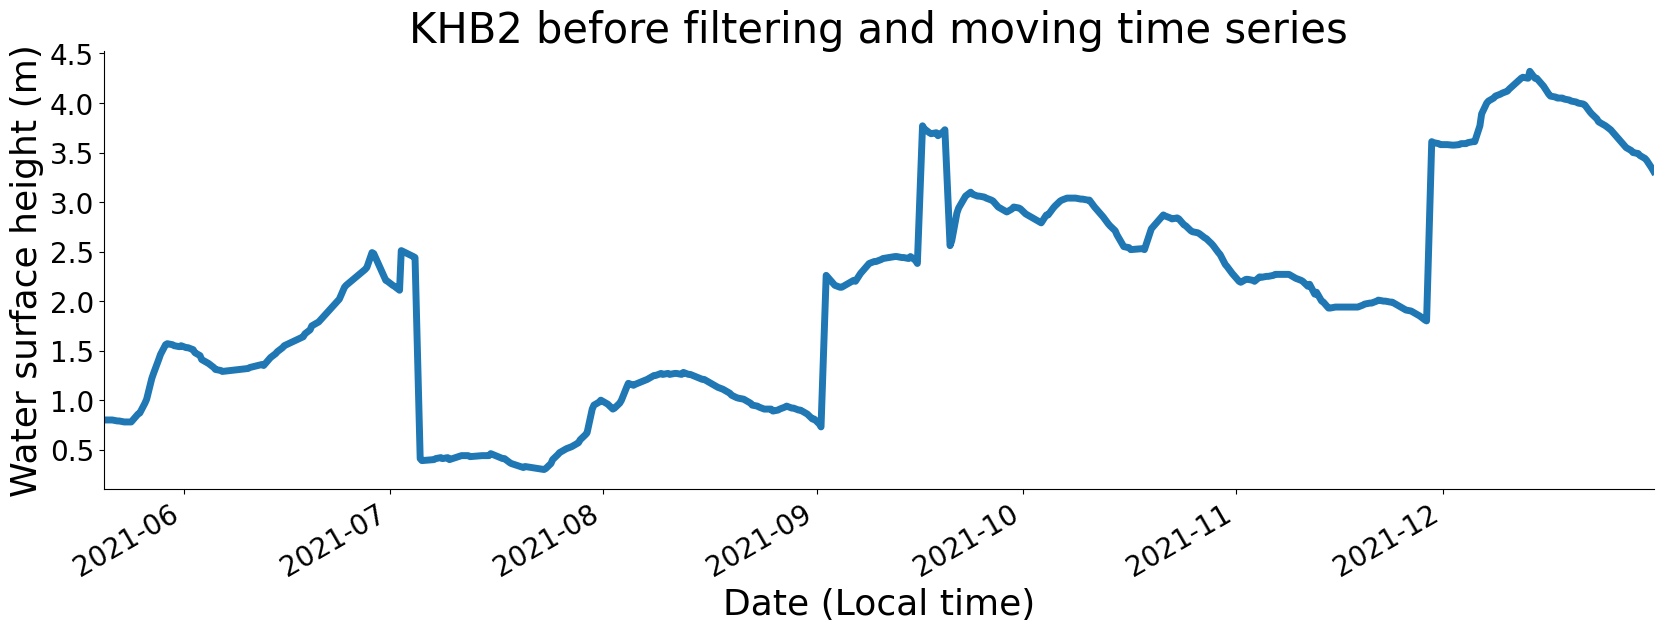

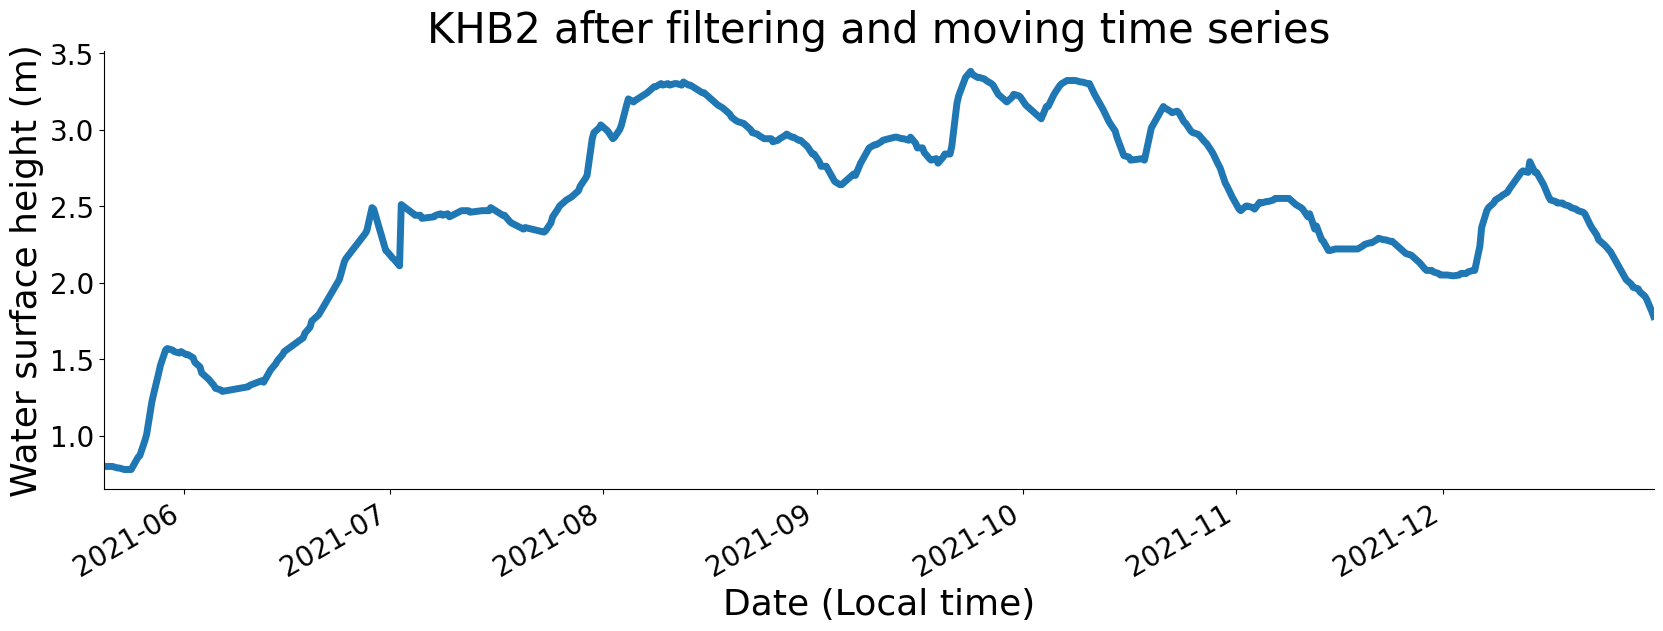

In [335]:
import matplotlib.dates as mdates
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='KHB2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.5
high_lim=.5

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)
df_diff_to_remove
date_fd='date'
diff_fd='diff'



if df_diff_to_remove.empty:
    df1=df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id]
    fig, ax=plt.subplots(figsize=(20, 6))
    ax.plot(df1[date_fd], df1[height_fd])
    plt.title(st_id+' Already ok', fontsize=20)
    # ax=plt.gcf()
    # label = ax.yaxis.get_major_ticks()[2].label
    ax.set_xlabel('Date (Local time)', fontsize=18)
    ax.set_ylabel('Water surface height (m)',fontsize=18)
    ax.set_yticklabels(ax.get_yticks(),size = 16)
    # ax.set_xticklabels(ax.get_xticks(),size = 16)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(fontsize=16)
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    
else:
    df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
    df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

    #plot goes in here
    title=' filtering and moving time series'
    labels={'title':{'label':title, 'size':30},
       'x':{'label':'Date (Local time)', 'font_lbl_s':26, 'tick_s':20,'freq_interval':1},
       'y':{'label':'Water surface height (m)', 'font_lbl_s':26,'tick_s':20 }
       }

    # labels=dict({'title': title, 'y': 'Water Surface Height (m)'})

    fig1, fig2=plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)

# ax=plt.gfc()

### Save figures for supplemental material in the paper

In [336]:
fig1.savefig('../data/for_paper/Fig_S1_a.png', transparent=True, dpi=300)
fig2.savefig('../data/for_paper/Fig_S1_b.png', transparent=True, dpi=300)

### Extract and move reference point of the stations TAB2
#### Reason: The gauge is moved during the monitoring, the reference point moves as well

/tmp/ipykernel_519712/2766265906.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
/tmp/ipykernel_519712/2766265906.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)


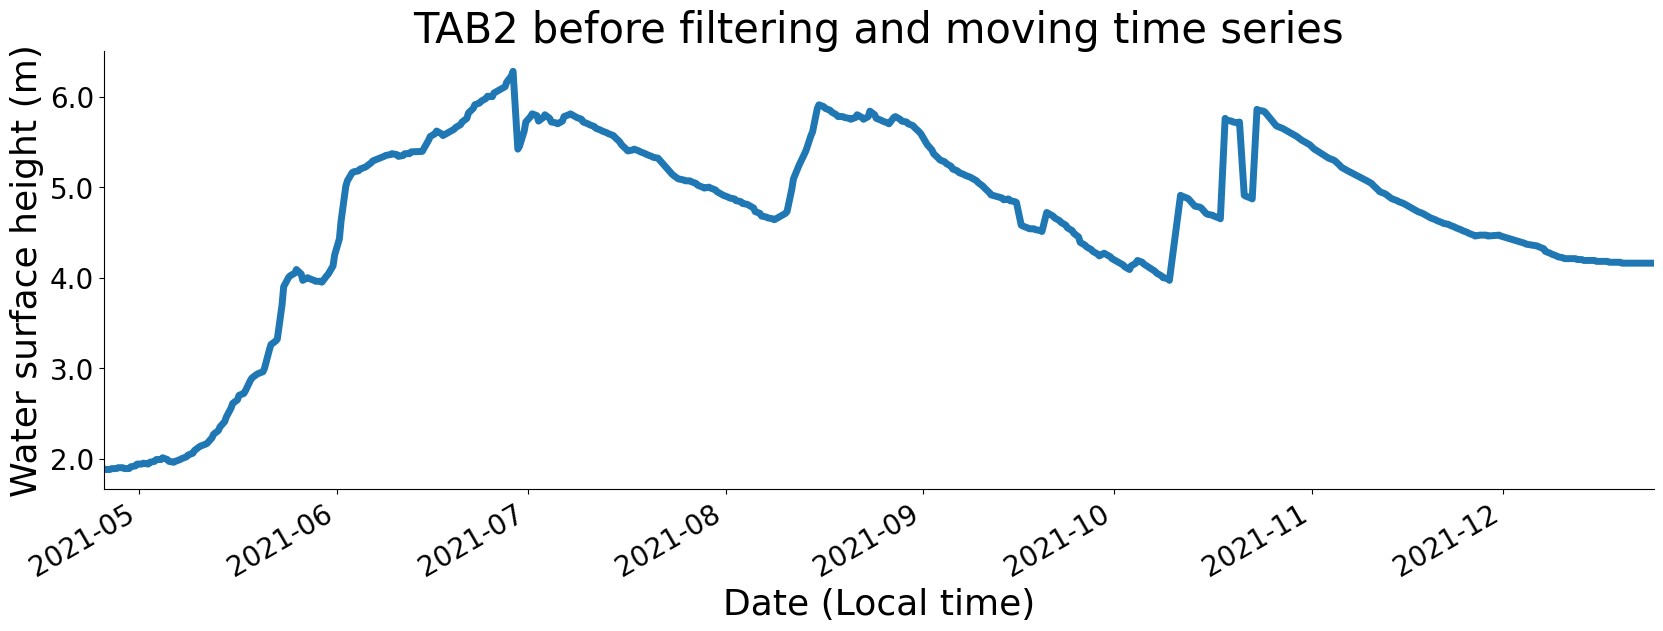

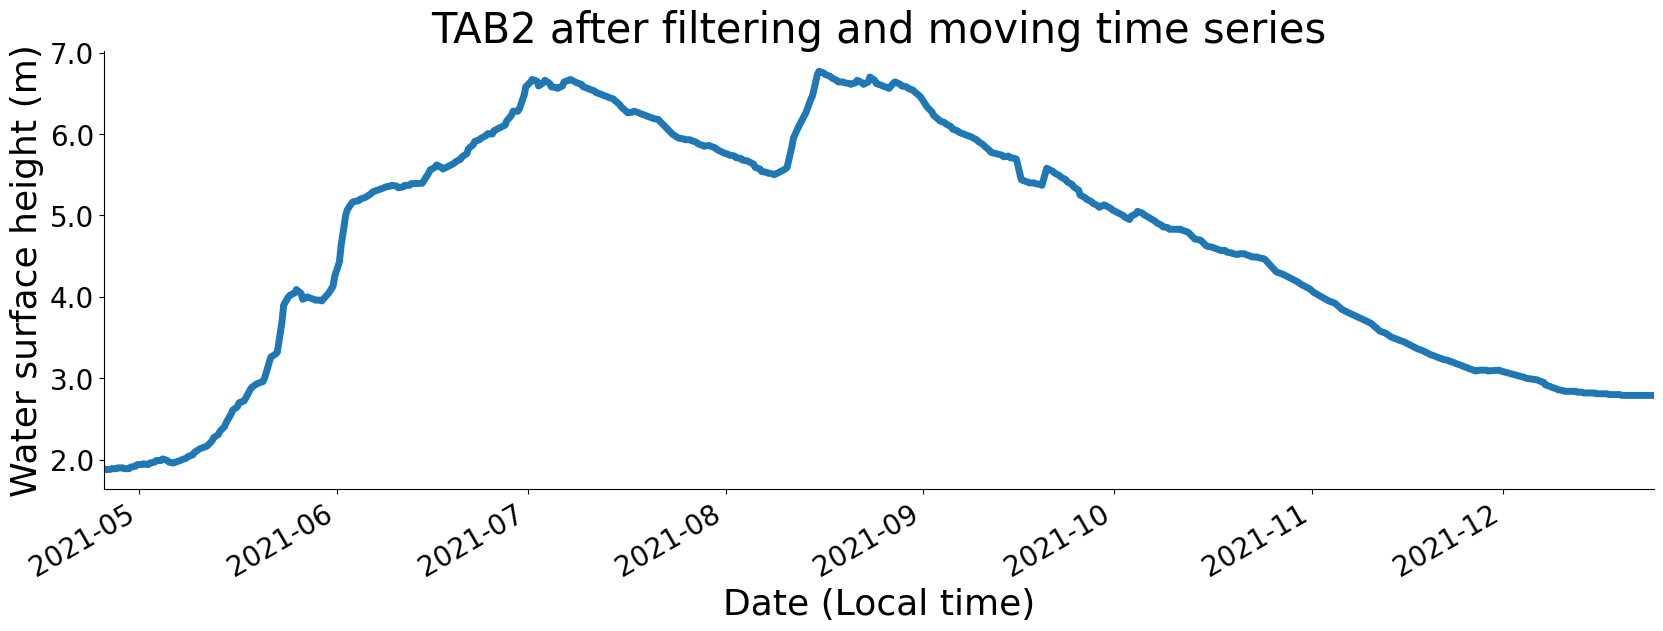

In [337]:
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='TAB2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.5
high_lim=.5

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)
df_diff_to_remove
date_fd='date'
diff_fd='diff'



if df_diff_to_remove.empty:
    df1=df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id]
    fig, ax=plt.subplots(figsize=(20, 6))
    ax.plot(df1[date_fd], df1[height_fd])
    plt.title(st_id+' Already ok', fontsize=20)
    # ax=plt.gcf()
    # label = ax.yaxis.get_major_ticks()[2].label
    ax.set_xlabel('Date (Local time)', fontsize=18)
    ax.set_ylabel('Water surface height (m)',fontsize=18)
    ax.set_yticklabels(ax.get_yticks(),size = 16)
    # ax.set_xticklabels(ax.get_xticks(),size = 16)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(fontsize=16)
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    
else:
    df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
    df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

    #plot goes in here
    title=' filtering and moving time series'
    labels={'title':{'label':title, 'size':30},
       'x':{'label':'Date (Local time)', 'font_lbl_s':26, 'tick_s':20,'freq_interval':1},
       'y':{'label':'Water surface height (m)', 'font_lbl_s':26,'tick_s':20 }
       }

    # labels=dict({'title': title, 'y': 'Water Surface Height (m)'})

    fig1, fig2=plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)


### Save figures for supplemental material in the paper

In [338]:
fig1.savefig('../data/for_paper/Fig_S1_c.png', transparent=True, dpi=300)
fig2.savefig('../data/for_paper/Fig_S1_d.png', transparent=True, dpi=300)

### Extract anomalous values stations MTN2 (Lake Mattamuskeet West)
#### Reason: There is a extreme value TO-DO: Pending to describe this better

/tmp/ipykernel_519712/2766265906.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
/tmp/ipykernel_519712/2766265906.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)


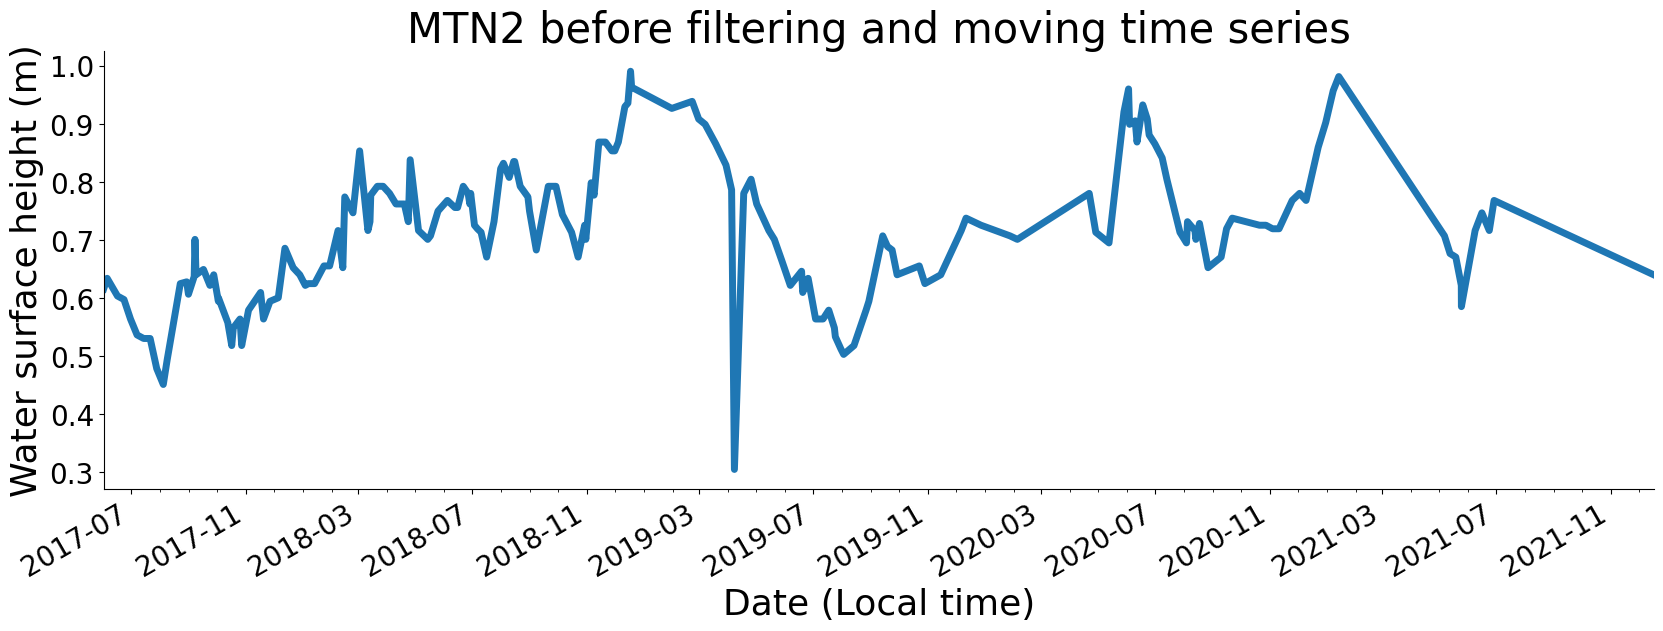

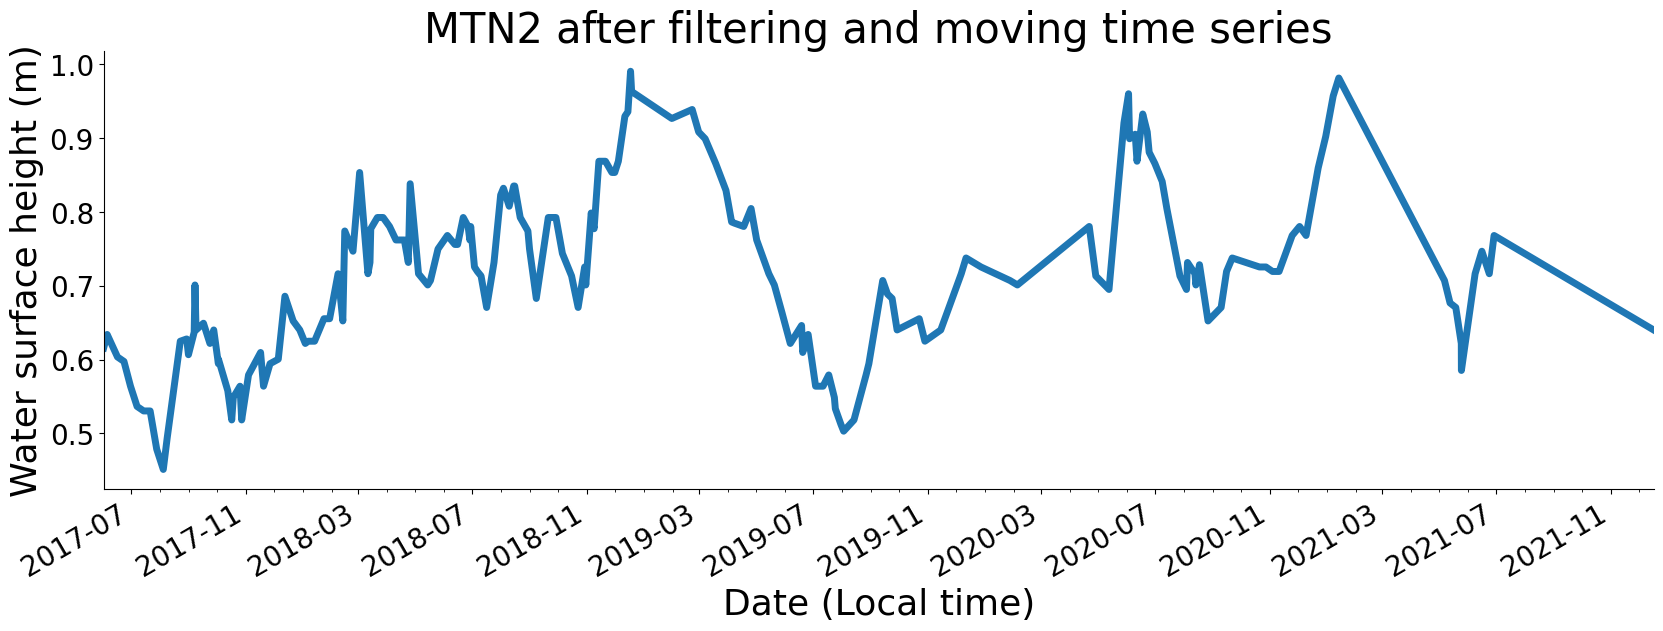

In [339]:
from matplotlib.ticker import FormatStrFormatter
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='MTN2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.4
high_lim=.4

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)
df_diff_to_remove
date_fd='date'
diff_fd='diff'



if df_diff_to_remove.empty:
    df1=df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id]
    fig, ax=plt.subplots(figsize=(20, 6))
    ax.plot(df1[date_fd], df1[height_fd])
    plt.title(st_id+' Already ok', fontsize=20)
    # ax=plt.gcf()
    # label = ax.yaxis.get_major_ticks()[2].label
    ax.set_xlabel('Date (Local time)', fontsize=18)
    ax.set_ylabel('Water surface height (m)',fontsize=18)
    
    # ax.set_xticklabels(ax.get_xticks(),size = 16)
    
    ax.set_yticklabels(ax.get_yticks(),size = 16)
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    plt.xticks(fontsize=16)
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    plt.gcf().autofmt_xdate()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    
else:
    df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
    df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

    #plot goes in here
    title=' filtering and moving time series'
    labels={'title':{'label':title, 'size':30},
       'x':{'label':'Date (Local time)', 'font_lbl_s':26, 'tick_s':20, 'freq_interval':4},
       'y':{'label':'Water surface height (m)', 'font_lbl_s':26,'tick_s':20 }
       }

    # labels=dict({'title': title, 'y': 'Water Surface Height (m)'})

    fig1, fig2=plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)


### Save figures for supplemental material in the paper

In [340]:
fig1.savefig('../data/for_paper/Fig_time_series correction.png', transparent=True, dpi=300)
fig2.savefig('../data/for_paper/Fig_time_series correction.png', transparent=True, dpi=300)

### Plot values from the two stations at Lake Mattamuskeet and Lake Phelps
#### For each lake
#### 1. Find values at the same date
#### 2. Plot the trend line
#### 3. Save the plot

In [478]:
def get_same_dates(df, gauge_id_fd, height_fd, date_fd, st_id_list, how='inner'):
    st_id_g1=st_id_list[0]
    st_id_g2=st_id_list[1]    

    df_G1=df[[gauge_id_fd,date_fd,height_fd]].loc[df[gauge_id_fd]==st_id_g1].copy()

    df_G2=df[[gauge_id_fd,date_fd,height_fd]].loc[df[gauge_id_fd]==st_id_g2].copy()

    df_common_dates=df_G1.merge(df_G2, on=date_fd, how=how).drop_duplicates()

    df_common_dates.rename(columns={'height_x':'height '+st_id_g1,'height_y':'height '+st_id_g2}, inplace=True)
    
    return df_common_dates
    

    
def plot_comparing_gauges(df,x,y, lb_x, lbx, normalized=False):
    
    if normalized:
        df[x+'_norm']=df[x]-df[x].mean()
        df[y+'_norm']=df[y]-df[y].mean()
        x=x+'_norm'
        y=y+'_norm'

    fig=px.scatter(df, x=x,y=y, trendline='ols', template='simple_white', color_discrete_sequence=['#1b9e77'], trendline_color_override="#7570b3")



    fig.for_each_yaxis(lambda y: y.update(title = ''))
    fig.for_each_xaxis(lambda y: y.update(title = ''))
    fig.add_annotation(x=-0.1,y=0.5,
                       text='<b>'+lb_y+'</b>', textangle=-90,
                       showarrow=False,
                       font=dict(size=18),
                       xref="paper", yref="paper")
    fig.add_annotation(x=0.5,y=-0.1,
                       text='<b>'+lb_x+'</b>', 
                       showarrow=False,
                       font=dict(size=18),
                       xref="paper", yref="paper")
    fig.add_annotation(x=0.5,y=-0.1,
                       text='<b>'+lb_x+'</b>', 
                       showarrow=False,
                       font=dict(size=18),
                       xref="paper", yref="paper")
    fig.update_xaxes(matches=None, showline=True, linewidth=2)
    fig.update_yaxes(matches=None, showline=True, linewidth=2)

    fig.update_layout(height=800, width=900,
                     yaxis = dict(tickfont = dict(size=18)),
                     xaxis = dict(tickfont = dict(size=18)))
    fig.show()
    results = px.get_trendline_results(fig)

    results.px_fit_results.iloc[0].summary()
    return fig

In [474]:
df=df_ground_ts.copy()

st_id_fd='gauge_id'
date_fd='decimal_y'
height_fd='height'

st_id_list=['VCN2','MTN2']
df_common_dates_VCMT=get_same_dates(df,st_id_fd,height_fd,date_fd, st_id_list)
# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 8,
                       ):
    print('Heights on the same date Lake Mattamuskeet\n',df_common_dates_VCMT)
    
st_id_list=['FDN2','PHN2']

df_common_dates_FDPH=get_same_dates(df,st_id_fd,height_fd,date_fd, st_id_list )
# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 8,
                       ):
    print('\nHeights on the same date Lake Phelps\n',df_common_dates_FDPH)

Heights on the same date Lake Mattamuskeet
     gauge_id_x      decimal_y  height VCN2 gauge_id_y  height MTN2
0         VCN2  2017.42568493     0.603504       MTN2     0.633984
2         VCN2  2017.45582192     0.621792       MTN2     0.603504
4         VCN2  2017.47488584     0.591312       MTN2     0.597408
6         VCN2  2017.49406393     0.557784       MTN2     0.563880
8         VCN2  2017.51324201     0.515112       MTN2     0.536448
10        VCN2  2017.53264840     0.512064       MTN2     0.530352
12        VCN2  2017.55159817     0.533400       MTN2     0.530352
14        VCN2  2017.57089041     0.451104       MTN2     0.478536
16        VCN2  2017.59018265     0.475488       MTN2     0.451104
18        VCN2  2017.68310502     0.728472       MTN2     0.701040
20        VCN2  2017.70799087     0.685800       MTN2     0.649224
22        VCN2  2017.75171233     0.655320       MTN2     0.594360
24        VCN2  2017.79543379     0.615696       MTN2     0.548640
26        VCN2  20

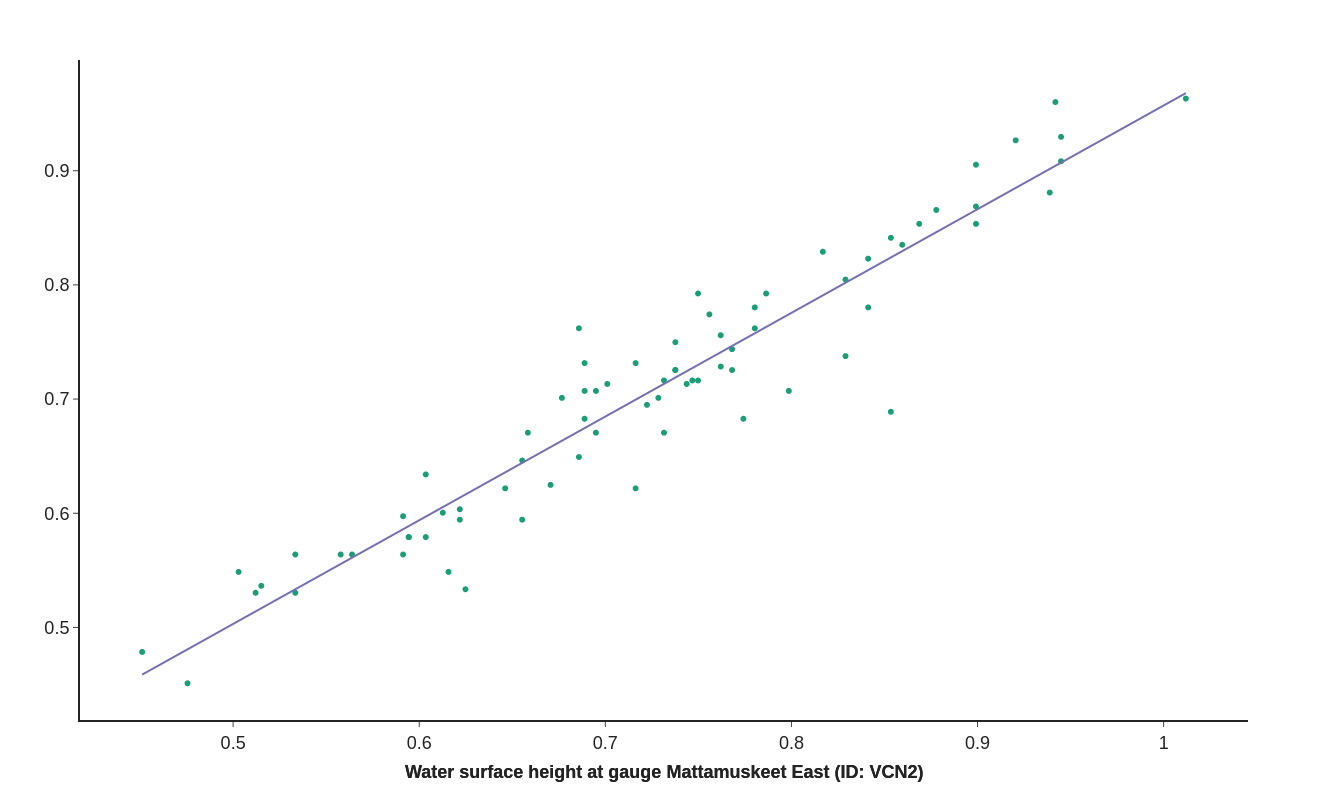

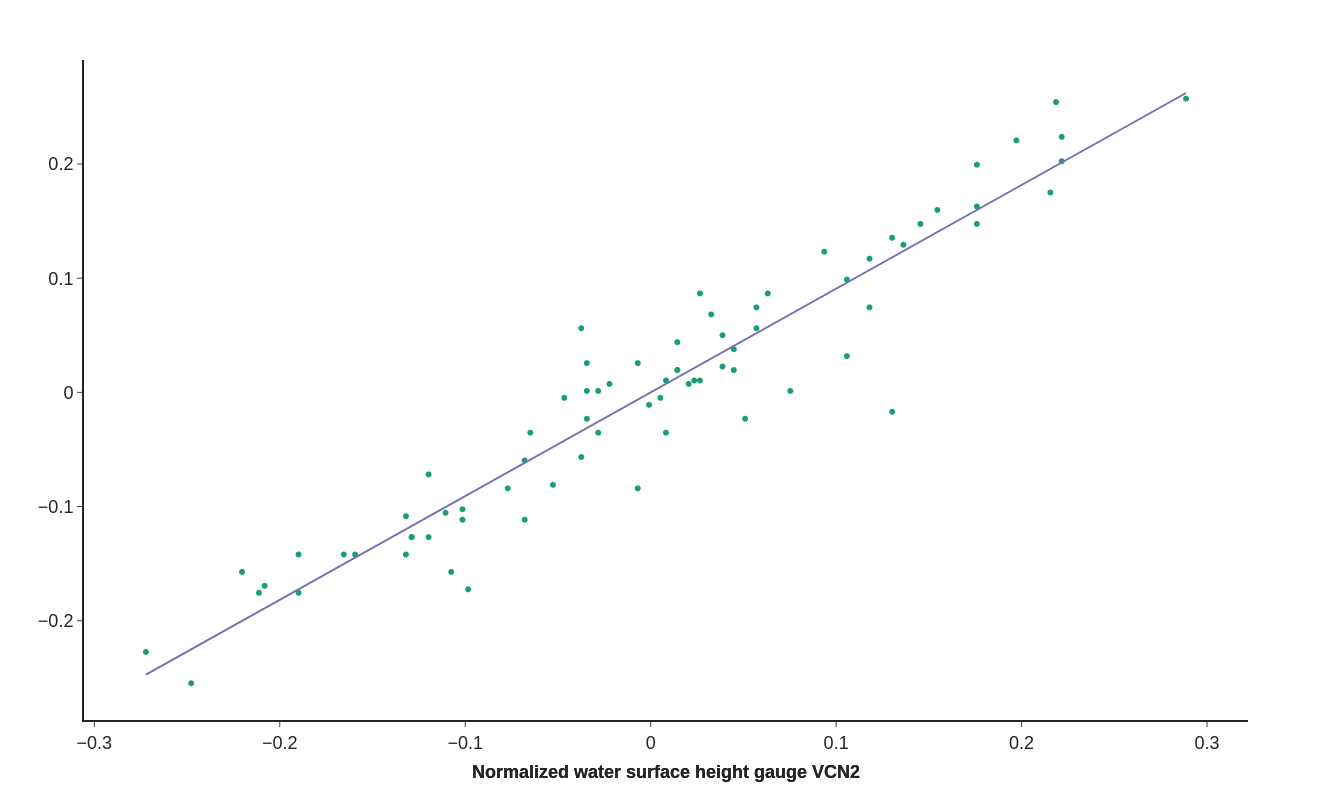

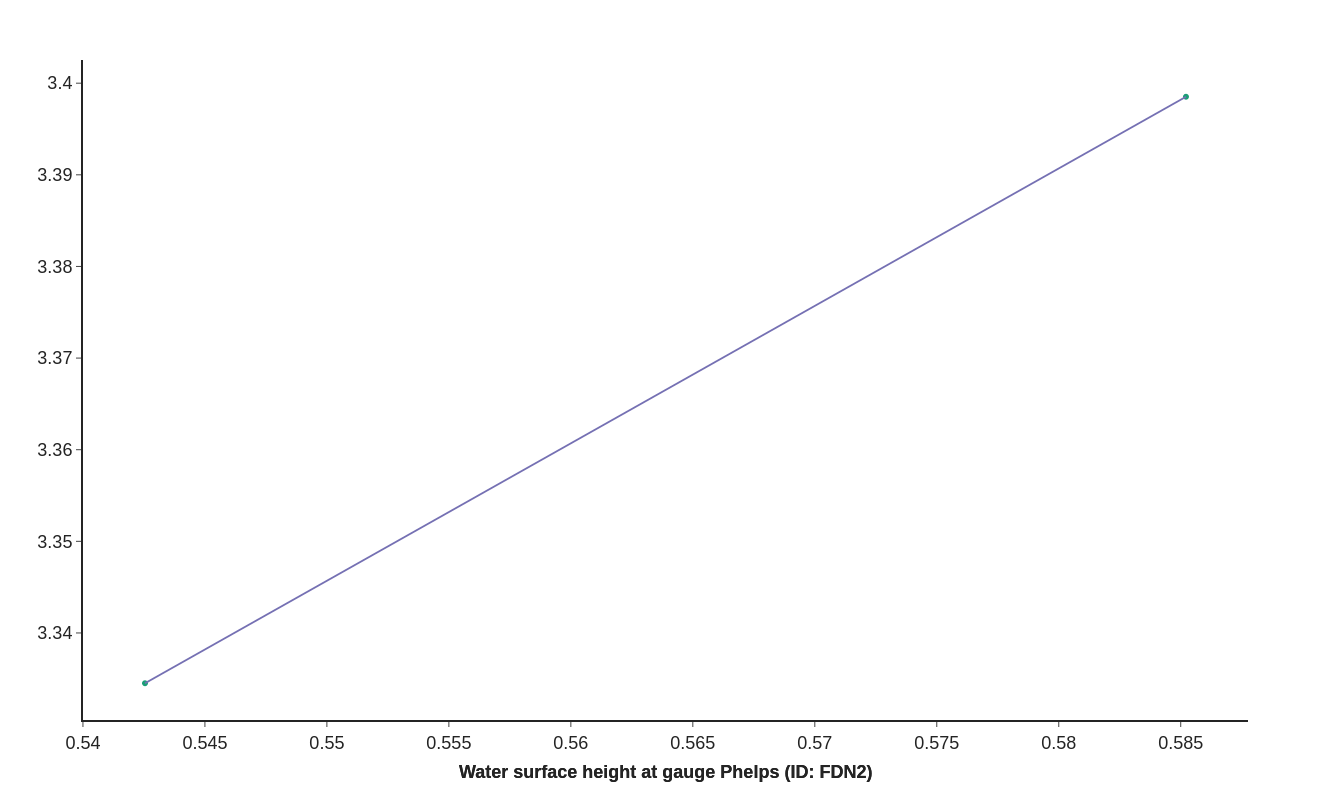

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 2 samples were given.

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning:

divide by zero encountered in divide

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning:

invalid value encountered in double_scalars

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1687: RuntimeWarning:

divide by zero encountered in double_scalars



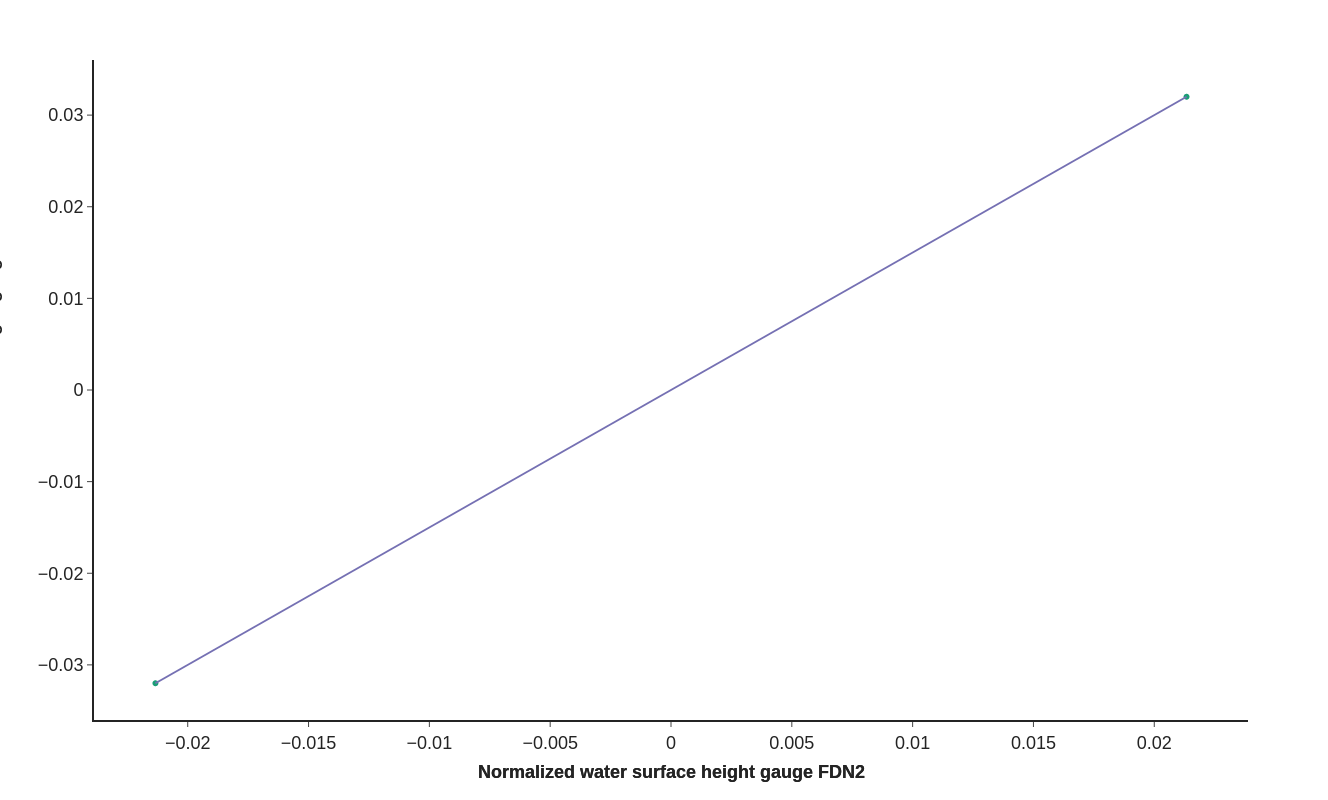

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 2 samples were given.

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning:

divide by zero encountered in divide

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.

In [479]:
import plotly.express as px
# plt.style.use('default')
# plt.rcParams["figure.figsize"] = (15,5)
lb_x='Water surface height at gauge Mattamuskeet East (ID: VCN2)'
lb_y='Water surface height at gauge Mattamuskeet West (ID: MTN2)'

df=df_common_dates_VCMT.copy()
x='height VCN2'
y='height MTN2'
figMM=plot_comparing_gauges(df,x,y, lb_x, lb_y)

lb_x='Normalized water surface height gauge VCN2'
lb_y='Normalized water surface height gauge MTN2'
figMM_N=plot_comparing_gauges(df,x,y, lb_x, lb_y, normalized=True)

lb_x='Water surface height at gauge Phelps (ID: FDN2)'
lb_y='Water surface height at gauge Phelps East (ID: PHN2)'

df=df_common_dates_FDPH.copy()
x='height FDN2'
y='height PHN2'

figPP=plot_comparing_gauges(df,x,y, lb_x, lb_y)


lb_x='Normalized water surface height gauge FDN2'
lb_y='Normalized water surface height gauge PHN2'
figPP_N=plot_comparing_gauges(df,x,y, lb_x, lb_y, normalized=True)

In [485]:
figMM.write_image('../data/for_paper/Fig_same_lake_two_gauges_Mattamuskeet.pdf')
figMM_N.write_image('../data/for_paper/Fig_same_lake_two_gauges_Mattamuskeet_norm.pdf')
figPP.write_image('../data/for_paper/Fig_same_lake_two_gauges_Phelps.pdf')
figPP_N.write_image('../data/for_paper/Fig_same_lake_two_gauges_Phelps_norm.pdf')

diff    0.204216
dtype: float64

### Explore other gauge in Lake Mattamuskeet VCN2 (Lake Mattamuskeet est)
### Plot VCN2 and MTN2

/tmp/ipykernel_519712/1579728843.py:26: UserWarning:

FixedFormatter should only be used together with FixedLocator



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_519712/1579728843.py", line 51, in <module>
    plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(), marker='*', label='MTN2', color='d95f02')
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/matplotlib/pyplot.py", line 2812, in plot
    @_copy_docstring_and_deprecators(Axes.scatter)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 1688, in plot
    Objects representing the plotted data.
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    args = args[1:]
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 544, in _plot_args
  File "/home/angelica

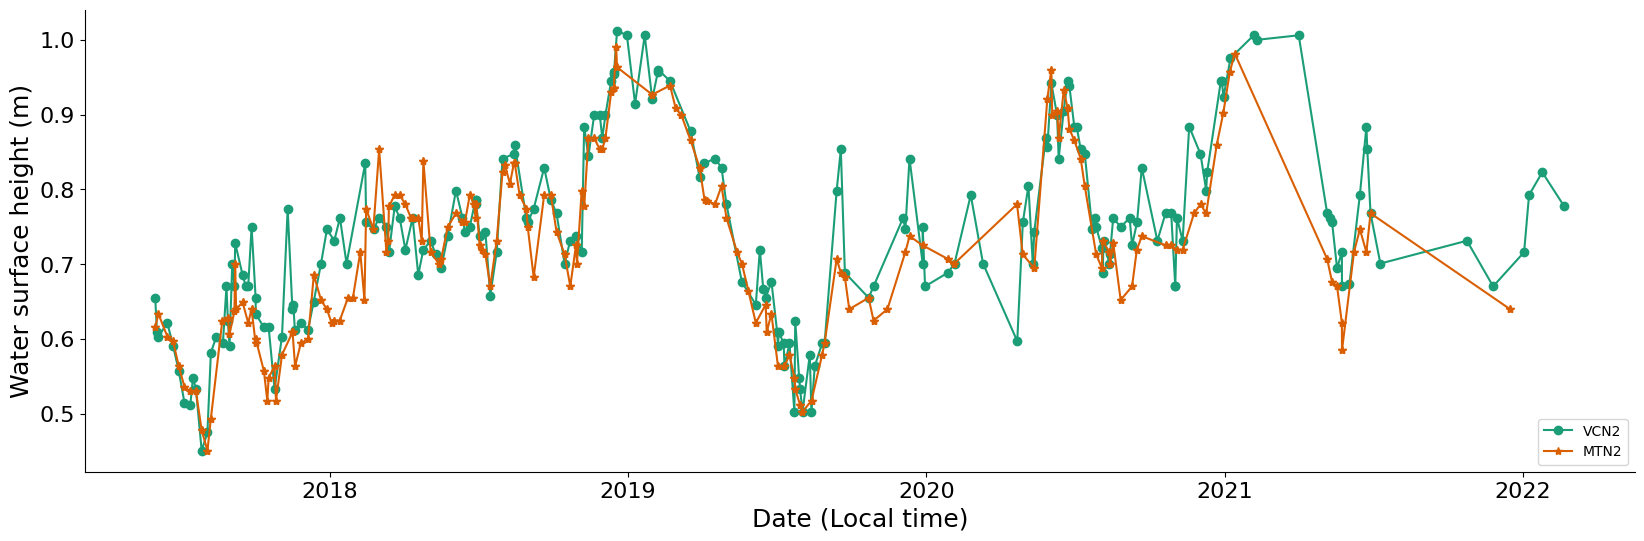

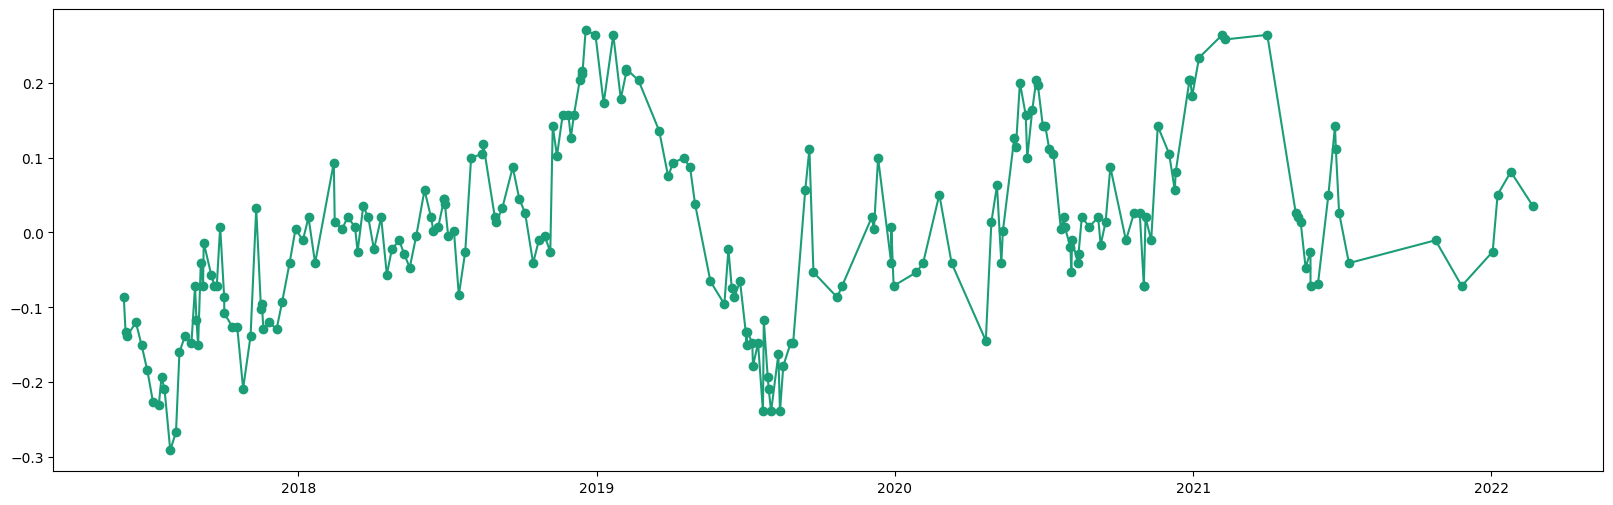

In [498]:
df_MTN2=df_ground_ts.loc[df_ground_ts[st_id_fd]=='MTN2'].copy()
df_VCN2=df_ground_ts.loc[df_ground_ts[st_id_fd]=='VCN2'].copy()


st_id_fd='gauge_id'
st_id='VCN2'
date_fd='decimal_y'
height_fd='height'

fig, ax=plt.subplots(figsize=(20, 6))

df1=df_VCN2
df1=df1.sort_values(by=date_fd)
# plt.plot(df1[date_fd], df1[height_fd]-df1[height_fd].mean(), marker='o', label='VCN2')
plt.plot(df1[date_fd], df1[height_fd], marker='o', label='VCN2', color='#1b9e77')

df2=df_MTN2
df2=df2.sort_values(by=date_fd)
# plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(), marker='*', label='MTN2')

plt.plot(df2[date_fd], df2[height_fd], marker='*', label='MTN2', color='#d95f02')

ax.set_xlabel('Date (Local time)', fontsize=18)
ax.set_ylabel('Water surface height (m)',fontsize=18)
    
ax.set_yticklabels(ax.get_yticks(),size = 16)
# Make ticks on occurrences of each month:
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(fontsize=16)
# ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
# plt.gcf().autofmt_xdate()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
for pos in ['top', 'right']:
    plt.gca().spines[pos].set_visible(False)

plt.legend(loc='lower right')

plt.figure(figsize=(20, 6))

df1=df_ground_ex
df1=df1.sort_values(by=date_fd)
plt.plot(df1[date_fd], df1[height_fd]-df1[height_fd].mean(), marker='o', color='#1b9e77')
# plt.plot(df1[date_fd], df1[height_fd], marker='o', label='VCN2')
df2=df_MTN2
df2=df2.sort_values(by=date_fd)
plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(), marker='*', label='MTN2', color='d95f02')

ax.set_xlabel('Date (Local time)', fontsize=18)
ax.set_ylabel('Water surface height change (m)',fontsize=18)
    
ax.set_yticklabels(ax.get_yticks(),size = 16)
# Make ticks on occurrences of each month:
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(fontsize=16)
# ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
# plt.gcf().autofmt_xdate()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
for pos in ['top', 'right']:
    plt.gca().spines[pos].set_visible(False)


plt.legend(loc='lower right')

print (df1.shape, df2.shape)

(238, 14) (258, 14)
(238, 14) (258, 14)


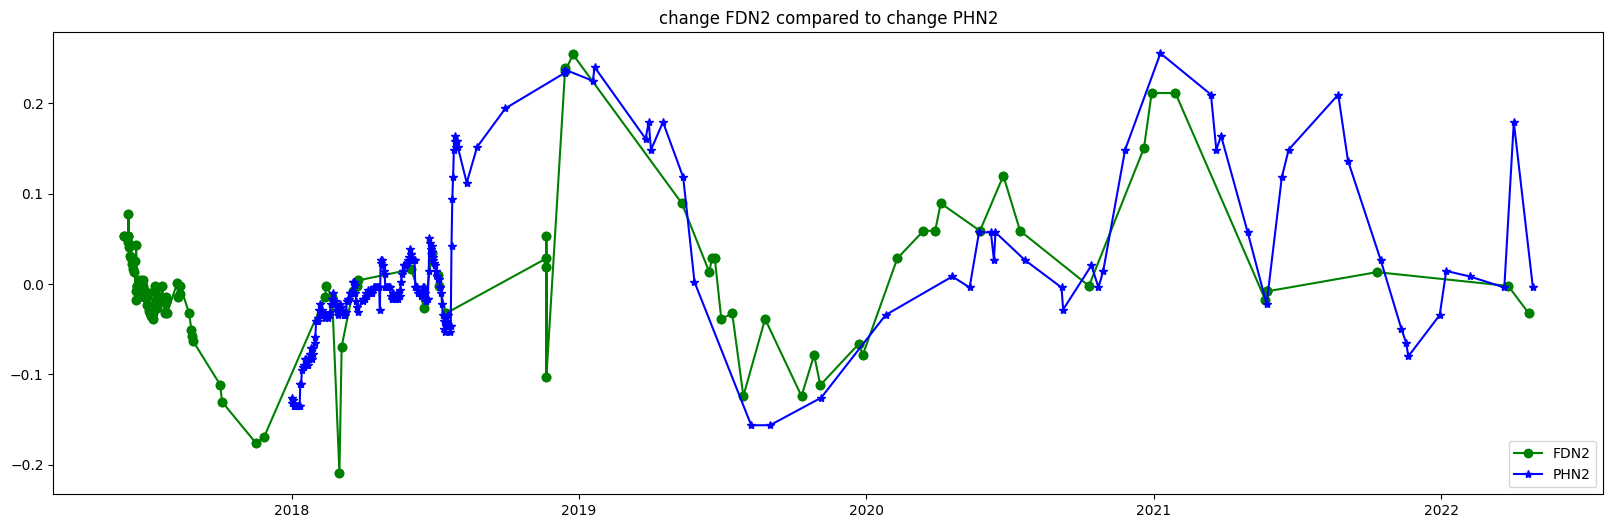

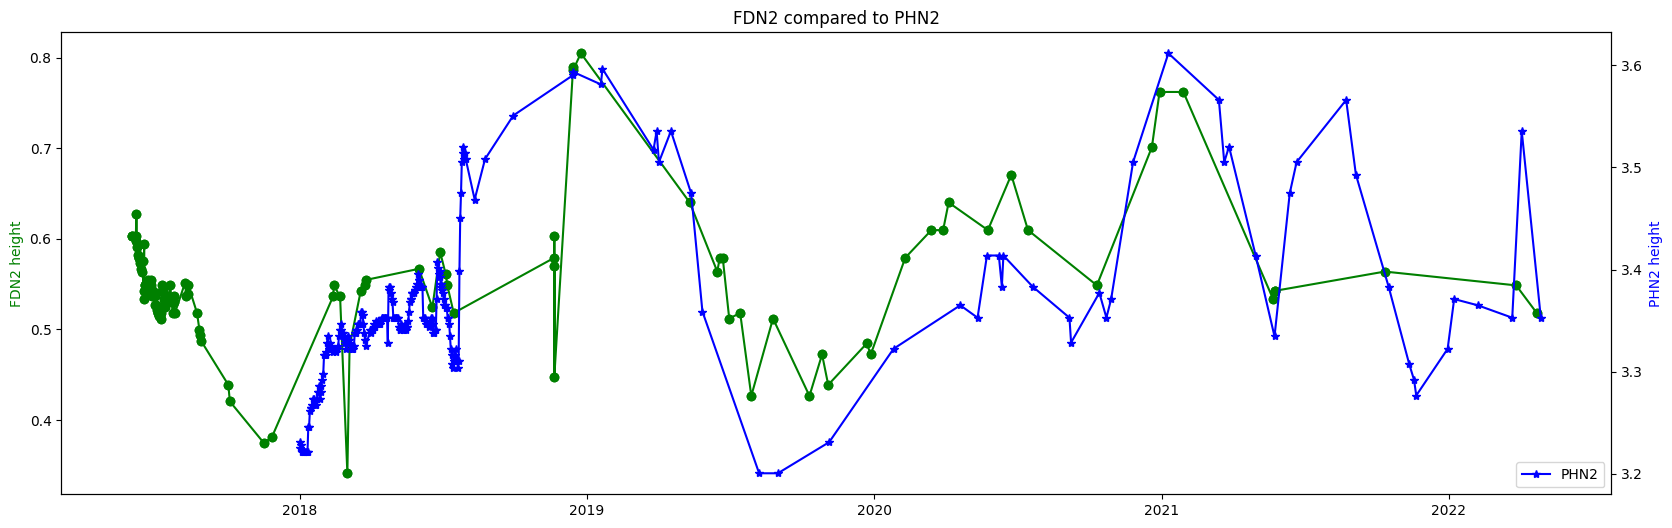

In [30]:
df_PHN2=df_ground_ts.loc[df_ground_ts[st_id_fd]=='PHN2'].copy()

df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='FDN2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.4
high_lim=.4

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)
df_ground_ex_PH, df_ground_re_PH,df_diff_to_remove_PH=extract_data_gauge(df_PHN2, st_id_fd, 'PHN2', date_fd, height_fd, low_lim, high_lim)

# df_ground_fixed=df_ground_ex.loc[df_ground_ex['date']!='2019-04-07 14:55:00']
# df_ground_ts=df_ground_expd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
# df1=df_ground_ex

plt.figure(figsize=(20, 6))

df1=df[df[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
plt.plot(df1[date_fd], df1[height_fd]-df1[height_fd].mean(), 'g-',marker='o', label='FDN2')
df2=df_PHN2
df2=df2.sort_values(by=date_fd)
plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(),'b-', marker='*', label='PHN2')
plt.title('change '+st_id+' compared to change '+'PHN2')
plt.legend(loc='lower right')
print (df1.shape, df2.shape)

fig, ax=plt.subplots(figsize=(20, 6))

ax2=ax.twinx()
df1=df[df[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
ax.plot(df1[date_fd], df1[height_fd], 'g-', marker='o', label='FDN2')
df2=df_PHN2
df2=df2.sort_values(by=date_fd)
ax2.plot(df2[date_fd], df2[height_fd], 'b-',marker='*', label='PHN2')

ax.set_ylabel('FDN2 height', color='g')
ax2.set_ylabel('PHN2 height', color='b')
plt.title(st_id+' compared to '+'PHN2')
plt.legend(loc='lower right')
print (df1.shape, df2.shape)

In [68]:
df_ground_ex.loc[df_ground_ex['diff']==df_ground_ex[['diff']].max().values[0]]


,gauge_id,source,decimal_y,height,date,year,month,day,hour,doy,lake_name,lake_id,diff,diff_time
329507,FDN2,LOCSS,2018.951826,0.789432,2018-12-14 10:41:49,2018,12,14,10,348,Lake Phelps,7320414542,0.341376,0.065411


### Extract anomalous values stations 12327
#### Reason: There is a extreme value TO-DO: Pending to describe this better

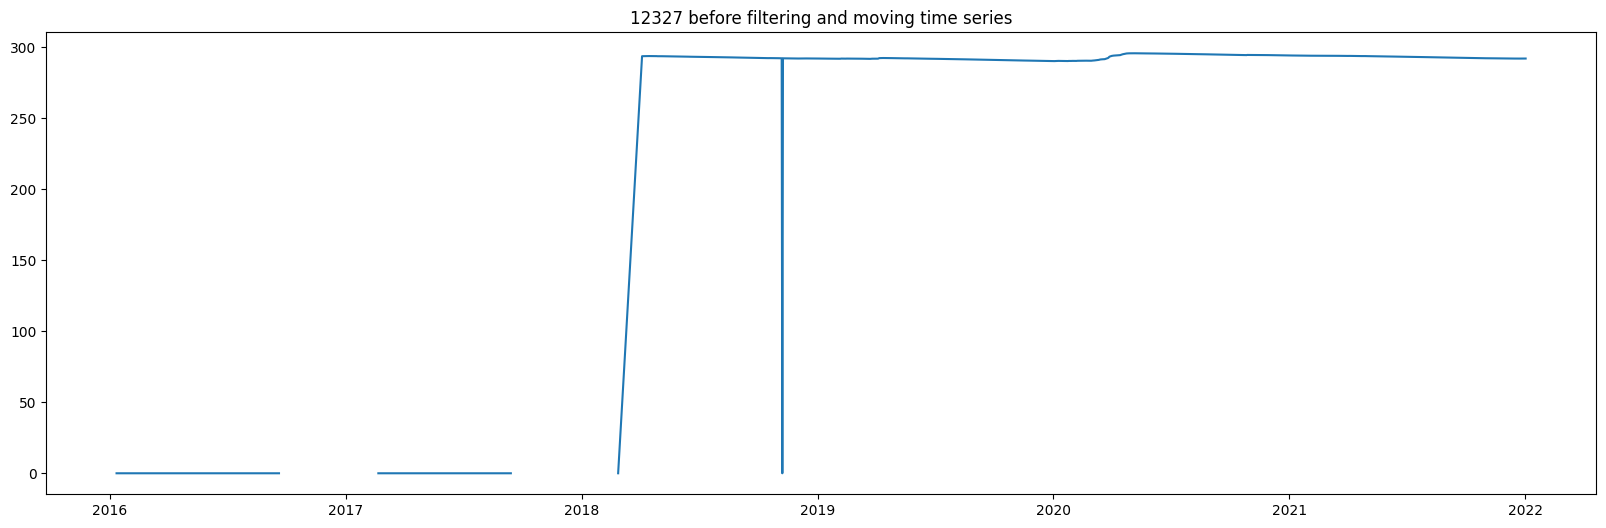

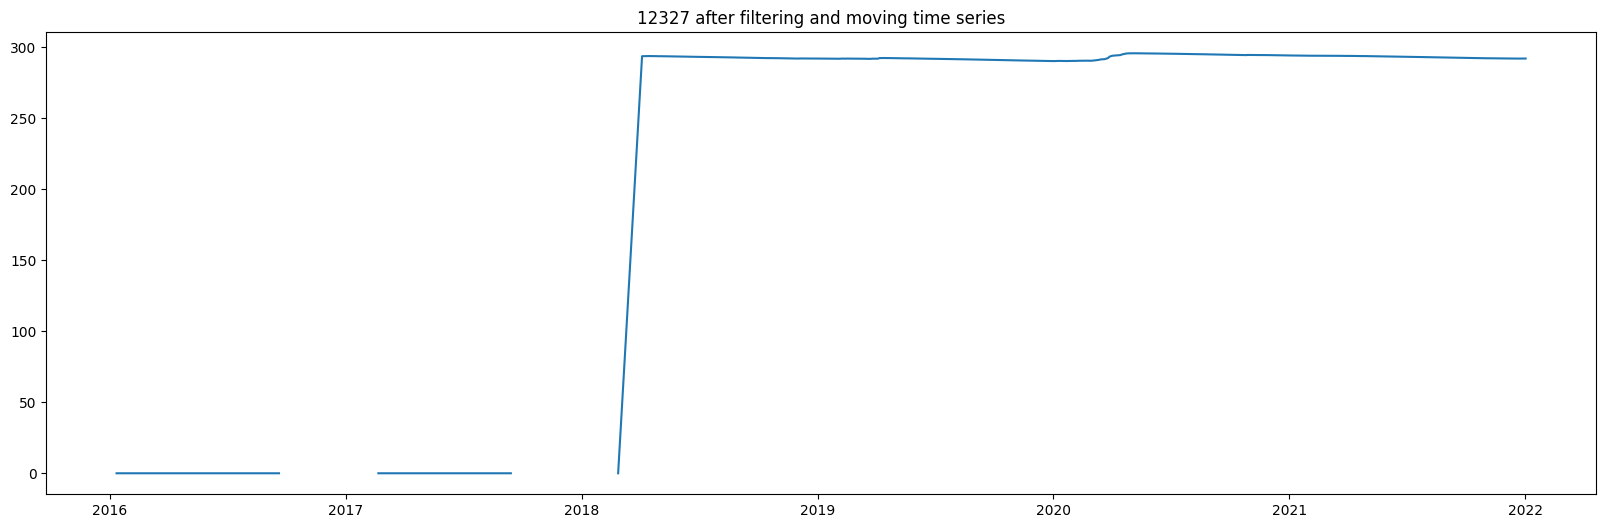

In [31]:
df=df_ground_ts.copy()
st_id='12327'
date_fd='decimal_y'
height_fd='height'
st_id_fd='gauge_id'
low_lim=-5
high_lim=5
df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

dates_to_remove=df_diff_to_remove.loc[df_diff_to_remove['diff_time']*365<1, 'date']
df_ground_fixed=df_ground_ex.loc[~df_ground_ex['date'].isin(dates_to_remove)]
df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
df1=df_ground_ex
title=' filtering and moving time series'
plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)


### Subset the time series to a period after 2018-04 station 12327
#### Reason: It seems a problem with the reference value at the begginning of the time series

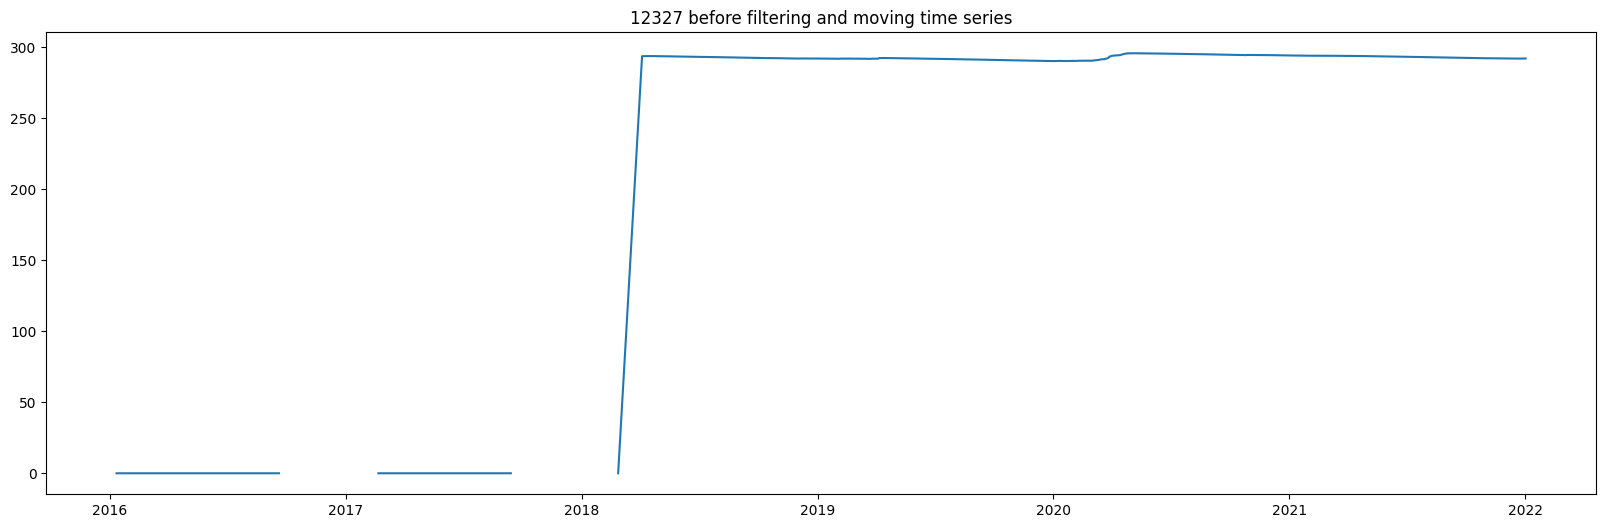

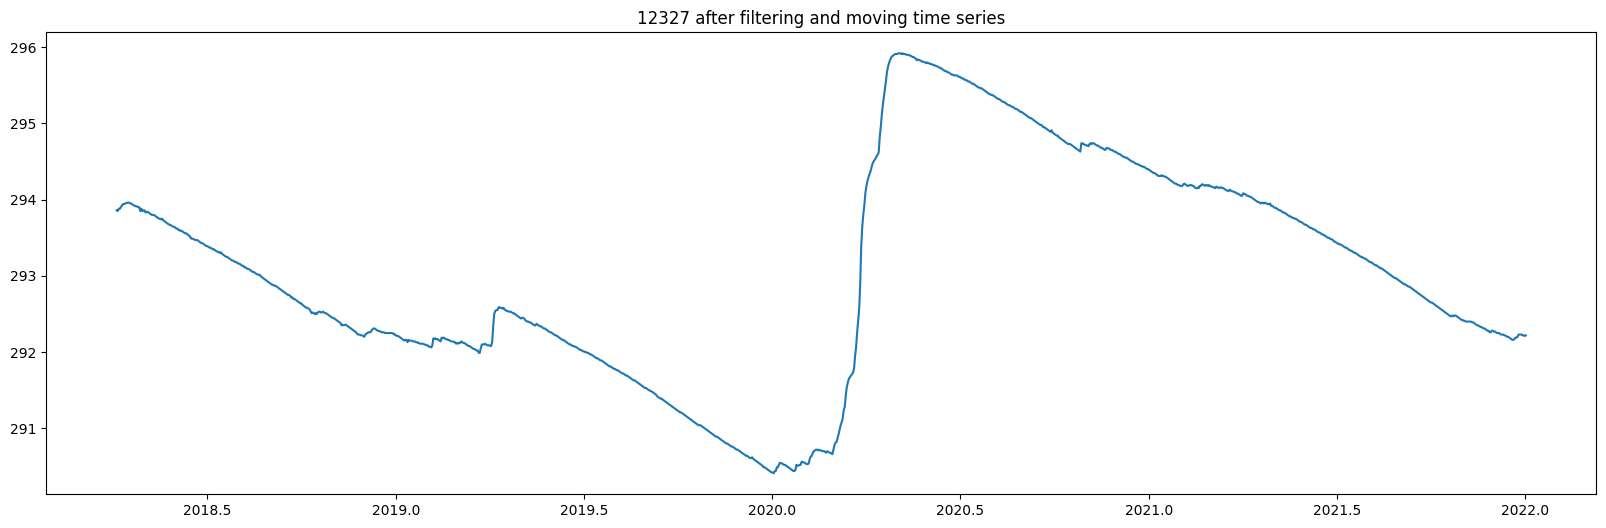

In [32]:
df=df_ground_ts.copy()
st_id='12327'
date_fd='decimal_y'
height_fd='height'
st_id_fd='gauge_id'

df1=df.loc[df['date']>'2018-04-04'] #This is the date when the big Jump occurs. Therefore the plot will be filtered from here 
df1=df1.sort_values(by=date_fd)

df_ground_ts=pd.concat((df_ground_re,df1), axis=0)


title=' filtering and moving time series'
plot_ts_preproc(df.loc[df[st_id_fd]==st_id],df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)


### Extract anomalous values station 12056
#### Reason: Differences of up to 8 m in a day

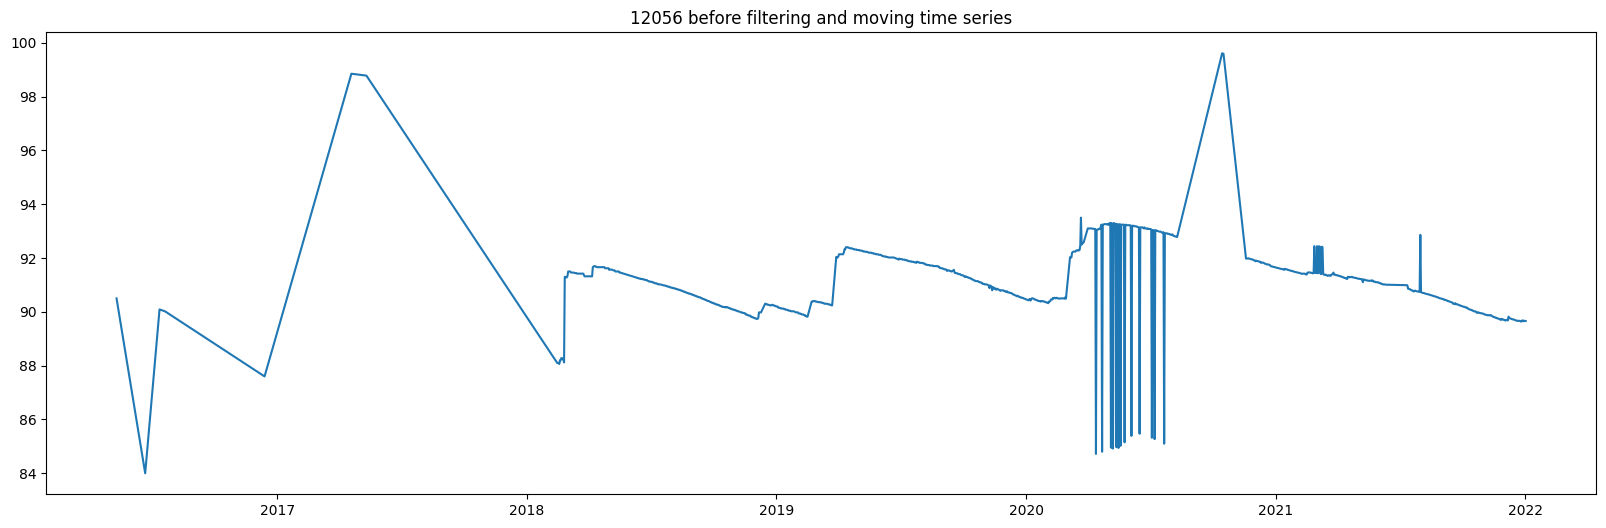

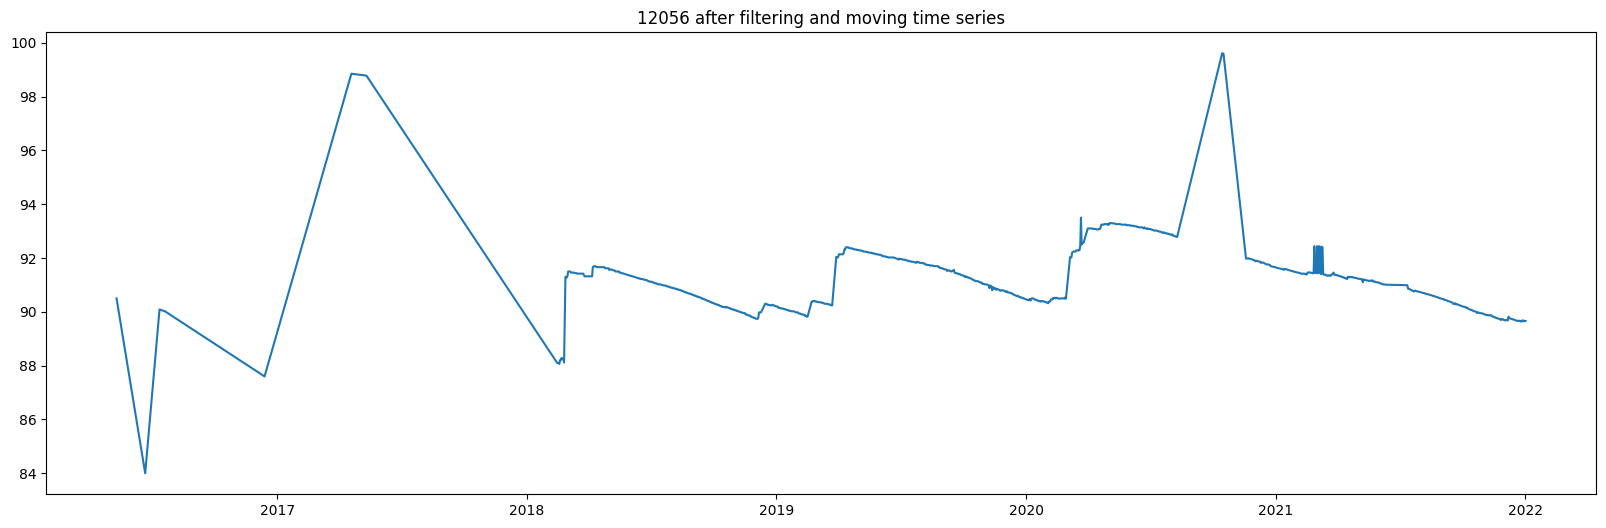

In [33]:
df=df_ground_ts.copy()
st_id='12056'
date_fd='decimal_y'
height_fd='height'
st_id_fd='gauge_id'

low_lim=-1.5
high_lim=1.5
df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

#Extract from this gauge those that are with differences more than 8 m in about a day
dates_to_remove=df_diff_to_remove.loc[df_diff_to_remove['diff_time']*365<1, 'date']
df_ground_fixed=df_ground_ex.loc[~df_ground_ex['date'].isin(dates_to_remove)]

#Date to remove 2020-05-07 because it is the only one in the middle of two days in which the change in water elevation was over 8.0 m
df_ground_fixed=df_ground_fixed.loc[df_ground_fixed['date']!='2020-05-07']

df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

title=' filtering and moving time series'
plot_ts_preproc(df.loc[df[st_id_fd]==st_id],df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, title)


In [288]:
df_ground_ts.columns

Index(['gauge_id', 'source', 'decimal_y', 'height', 'date', 'year', 'month',
       'day', 'hour', 'doy', 'lake_name', 'lake_id', 'diff', 'diff_time'],
      dtype='object')

# 4. Save dataframe will all the time series preprocessed 

In [17]:
time_file=datetime.now().strftime("%Y%m%d_%H_%M")
# df_ground_ts.to_csv('../data/results/data_preprocessed.csv', sep=',')
#Backup
df_ground_ts.to_csv('../data/results/data_preprocessed_'+time_file+'.csv', sep=',')

In [18]:
time_file

'20230503_12_13'

In [34]:
#Only if data has been generated
# df_ground_ts=pd.read_csv('../data/results/data_preprocessed_20230329_14_22.csv', sep=',', low_memory=False, parse_dates=['date'])

df_ground_ts.info()
# import icecream as ic

<class 'pandas.core.frame.DataFrame'>
Index: 452807 entries, 0 to 363117
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   gauge_id   452807 non-null  object        
 1   source     452807 non-null  object        
 2   decimal_y  452807 non-null  float64       
 3   height     452199 non-null  float64       
 4   date       452807 non-null  datetime64[ns]
 5   year       452807 non-null  int32         
 6   month      452807 non-null  int32         
 7   day        452807 non-null  int32         
 8   hour       452807 non-null  int64         
 9   doy        452807 non-null  int32         
 10  lake_name  202095 non-null  object        
 11  lake_id    202095 non-null  object        
 12  diff       5937 non-null    float64       
 13  diff_time  5937 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int32(4), int64(1), object(4)
memory usage: 44.9+ MB


# 5. Preprocess altis data of the selected lakes 

In [47]:



#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'

time_fig=datetime.now().strftime("%Y%m%d_%H_%M")

df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()
    

tf=TimezoneFinder()

#Filter to lakes approved
#---------------------------
# approve_locss=df_sel_lakes.loc[df_sel_lakes['AprovedFor']==1]['gauge_id'].values #['HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','KHB2']

#HURRY Parch code so it works with the new gauges at the two lakes that have two gauges
# Fix, modify the shapefile so it can get the coordinates of the two gauges


# altis_csv=altis_csv.loc[altis_csv['station_id'].isin(approve_locss)]

lon_fd='lon'
lat_fd='lat'

df_gts=df_ground_ts.copy()

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
n_obs_altis='number of sample' #Number of observations
nodataalti=-9999

wse_ref='e'
i=1

#################CHANGE WITH N COMPARISON ####################
#----ALL
this_source='ALL'

#----ARHN
# this_source='ARHN'

##---LOCSS
# this_source='LOCSS'

#---USGS
# this_source='USGS'

##----RVBR
# this_source='RVBR'

#-----ICECV

# this_source='ICECV'
###########################################################

if this_source not in ['ALL', 'ICECV']:
    altis_csv=altis_csv.loc[altis_csv['source']==this_source].copy()

data_source=this_source

altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
#filter only altis time series with ground observations
altis_w_gts_csv=altis_csv.loc[altis_csv['lake_id'].notna()]

altis_w_gts_csv=altis_w_gts_csv.sort_values(by='source')

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    lake_id=str(int(row['lake_id']))
    orbit_nu=int(row['orbit'])
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,n_obs_altis,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,n_obs_altis, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), 'Gauge ID: '+st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape)+' Lake ID: '+lake_id)
    
    # print(df_altis.columns)
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        lake_name=df_ground_st['lake_name'].iloc[0]
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st['altis_d_1']=altis_name
        df_ground_st['orbit']=orbit_nu
        #Get the dates of altis
        # ic(df_altis[altis_date_fd].dt.normalize().max())
        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                                    date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=True, ndays=10)

#         
        
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        # print(df_altis_c.head())
        delta=5
        for delta in range (3,5):
            median_fd='median_d_'+str(delta)
            mean_fd='mean_d_'+str(delta)
            std_fd='std_d_'+str(delta)
            mad_fd='mad_d_'+str(delta) #Median absolute deviation
            count_fd='count_d_'+str(delta)
        
            #second approach, the closest date
            #delta=5
            val_cd_fd='val_cd_d_'+str(delta)
            criteria_fd='type_cd_d_'+str(delta)
            closer_dt_fd='ndays_cd_d_'+str(delta)
            mea_cd_fd='mea_cd_d_'+str(delta)
            std_cd_fd='std_cd_d_'+str(delta)
            mad_cd_fd='mad_cd_d_'+str(delta) #Median absolute deviation
            n_cd_fd='n_cd_d_'+str(delta)
            # Get moving windows
            df_altis_c[[median_fd,mad_fd, mean_fd, std_fd,count_fd]]=df_altis_c.apply(lambda x: moving_window_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc'), axis=1).apply(pd.Series)
        
            # Get closer value around a date
            df_altis_c[[val_cd_fd,criteria_fd,closer_dt_fd,mea_cd_fd, mad_cd_fd, std_cd_fd,n_cd_fd]]=df_altis_c.apply(lambda x: closer_value_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc'), axis=1).apply(pd.Series)
        #Get interpolated data 
        datast1_2_ts2dy, corr_ts1ts2, ns_ts2, rmsd_ts2, ampl_ts1=interp_ts12ts2_stat(df_ground_c['decimal_y'].to_numpy(), df_ground_c['height'].to_numpy(), 
                                        df_altis_c['decimal_y'].to_numpy(), df_altis_c['height'].to_numpy())
        
        df_altis_c['int_height']=pd.Series(datast1_2_ts2dy)
        
        #add columns
        df_altis_c['lake_name']=lake_name
        df_altis_c['source']=df_ground_c['source'].iloc[0]
        df_altis_c['lake_id']=lake_id
        df_altis_c['orbit']=orbit_nu
        df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
        df_final_ground=pd.concat((df_final_ground,df_ground_c), axis=0)
    

df_final_ground=df_final_ground.rename(columns={'altis_d_1':'name_altis'}, errors='raise')
df_final_altis=df_final_altis.rename(columns={'ground_st_1':'gauge_id'}, errors='raise')



Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Gauge ID: 1824 ground_st: True df_altis: (73, 9) Lake ID: 6610142963
Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN Gauge ID: 2028 ground_st: True df_altis: (104, 9) Lake ID: 6620000613
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN Gauge ID: 2028 ground_st: True df_altis: (157, 9) Lake ID: 6620000613
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Gauge ID: 2028 ground_st: True df_altis: (77, 9) Lake ID: 6620000613
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Gauge ID: 2234 ground_st: True df_altis: (76, 9) Lake ID: 6610149612
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Gauge ID: 2234 ground_st: True df_altis: (75, 9) Lake ID: 6610149612
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Gauge ID: 2316 ground_st: True df_altis: (41, 9) Lake ID: 6530064712
Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN Gauge ID: HMT2 ground_st: True df_

In [48]:
df_final_altis

,decimal_y,height,nobs_altis,year,month,day,hour,date,name_altis,gauge_id,...,ndays_cd_d_4,mea_cd_d_4,mad_cd_d_4,std_cd_d_4,n_cd_d_4,int_height,lake_name,source,lake_id,orbit
0,2016.397797,826.443375,5.0,2016,5,25,14,2016-05-25 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,...,0.125000,NaN,NaN,NaN,1.0,0.868646,Lago Mascardi,ARHN,6610142963,281
1,2016.471568,826.397191,5.0,2016,6,21,14,2016-06-21 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,...,0.125000,NaN,NaN,NaN,1.0,0.850000,Lago Mascardi,ARHN,6610142963,281
2,2016.545338,826.459015,3.0,2016,7,18,14,2016-07-18 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,...,0.125000,NaN,NaN,NaN,1.0,0.832708,Lago Mascardi,ARHN,6610142963,281
3,2016.619109,826.637026,4.0,2016,8,14,14,2016-08-14 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,...,0.125000,NaN,NaN,NaN,1.0,1.042708,Lago Mascardi,ARHN,6610142963,281
4,2016.692879,826.851679,5.0,2016,9,10,14,2016-09-10 14:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,1824,...,0.125000,NaN,NaN,NaN,1.0,1.331354,Lago Mascardi,ARHN,6610142963,281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2021.578505,243.597359,9.0,2021,7,31,3,2021-07-31 03:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880,...,0.083333,276.420072,0.0,0.0,2.0,276.423234,Rathbun Lake,USGS,7420464262,318
73,2021.652477,242.944831,13.0,2021,8,27,3,2021-08-27 03:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880,...,0.083333,275.752560,0.0,0.0,2.0,275.753614,Rathbun Lake,USGS,7420464262,318
74,2021.726450,243.032823,7.0,2021,9,23,3,2021-09-23 03:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880,...,0.083333,275.639784,0.0,0.0,2.0,275.642946,Rathbun Lake,USGS,7420464262,318
75,2021.800422,242.857409,9.0,2021,10,20,3,2021-10-20 03:00:00+00:00,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880,...,0.083333,275.587968,0.0,0.0,2.0,275.586914,Rathbun Lake,USGS,7420464262,318


In [49]:
df_final_altis.gauge_id.unique()


array(['1824', '2028', '2234', '2316', 'HMT2', 'KHB2', 'MAB2', 'MCW2',
       'MRP2', 'MTN2', 'PAW2', 'PHN2', 'RLH2', 'SAW2', 'FDN2', 'SLL2',
       'SPA2', 'TAB2', 'VCN2', 'QUL2', 'BTN2', 'CFN2', 'YSL2', 'WEW2',
       'BLB2', '12056', '12030', '12036', '19060', '19069', '19126',
       '12327', '2464800', '6604000', '6903880'], dtype=object)

In [50]:
#Parching FDN2 and VCN2
df_final_altis.loc[df_final_altis['gauge_id']=='FDN2', 'lake_name']= 'Lake Phelps West' #df_final_altis.loc[df_final_altis['gauge_id']=='PHN2', 'lake_name'].iloc[0]
df_final_altis.loc[df_final_altis['gauge_id']=='PHN2', 'lake_name']= df_final_altis.loc[df_final_altis['gauge_id']=='FDN2', 'lake_name'].iloc[0][:-4]+ ' East'
# df_final_altis.loc[df_final_altis['gauge_id']=='PHN2', 'lake_name']
df_final_altis.loc[df_final_altis['gauge_id']=='VCN2', 'lake_name']= df_final_altis.loc[df_final_altis['gauge_id']=='MTN2', 'lake_name'].iloc[0][:-4]+'East'
df_final_altis.loc[df_final_altis['gauge_id']=='MAB2', 'lake_name']='Matian Haor' #Althought this lake is not included given deliation
# df_final_altis.loc[df_final_altis['gauge_id']=='VCN2', 'lake_name']

In [51]:
df_final_altis.loc[df_final_altis['lake_name'].isna(), 'gauge_id'].unique()#=='MTN2', 'lake_name'].iloc[0]

array([], dtype=object)

### Mark only the lakes that will be in the paper

In [52]:
#Add a mark to only places that have been selected for evaluation
gauges_to_process=df_sel_lakes.loc[df_sel_lakes.ol_Aproved==1, 'gauge_id']
f=[gauges_to_process.copy(),pd.Series(['VCN2', 'FDN2'], name='gauge_id')]

approve_paper =pd.concat(f, axis=0)

df_final_altis['for_paper']=None
df_final_ground['for_paper']=None
df_final_altis.loc[df_final_altis['gauge_id'].isin(approve_paper), 'for_paper']='Y'
df_final_ground.loc[df_final_ground['gauge_id'].isin(approve_paper),'for_paper']='Y'

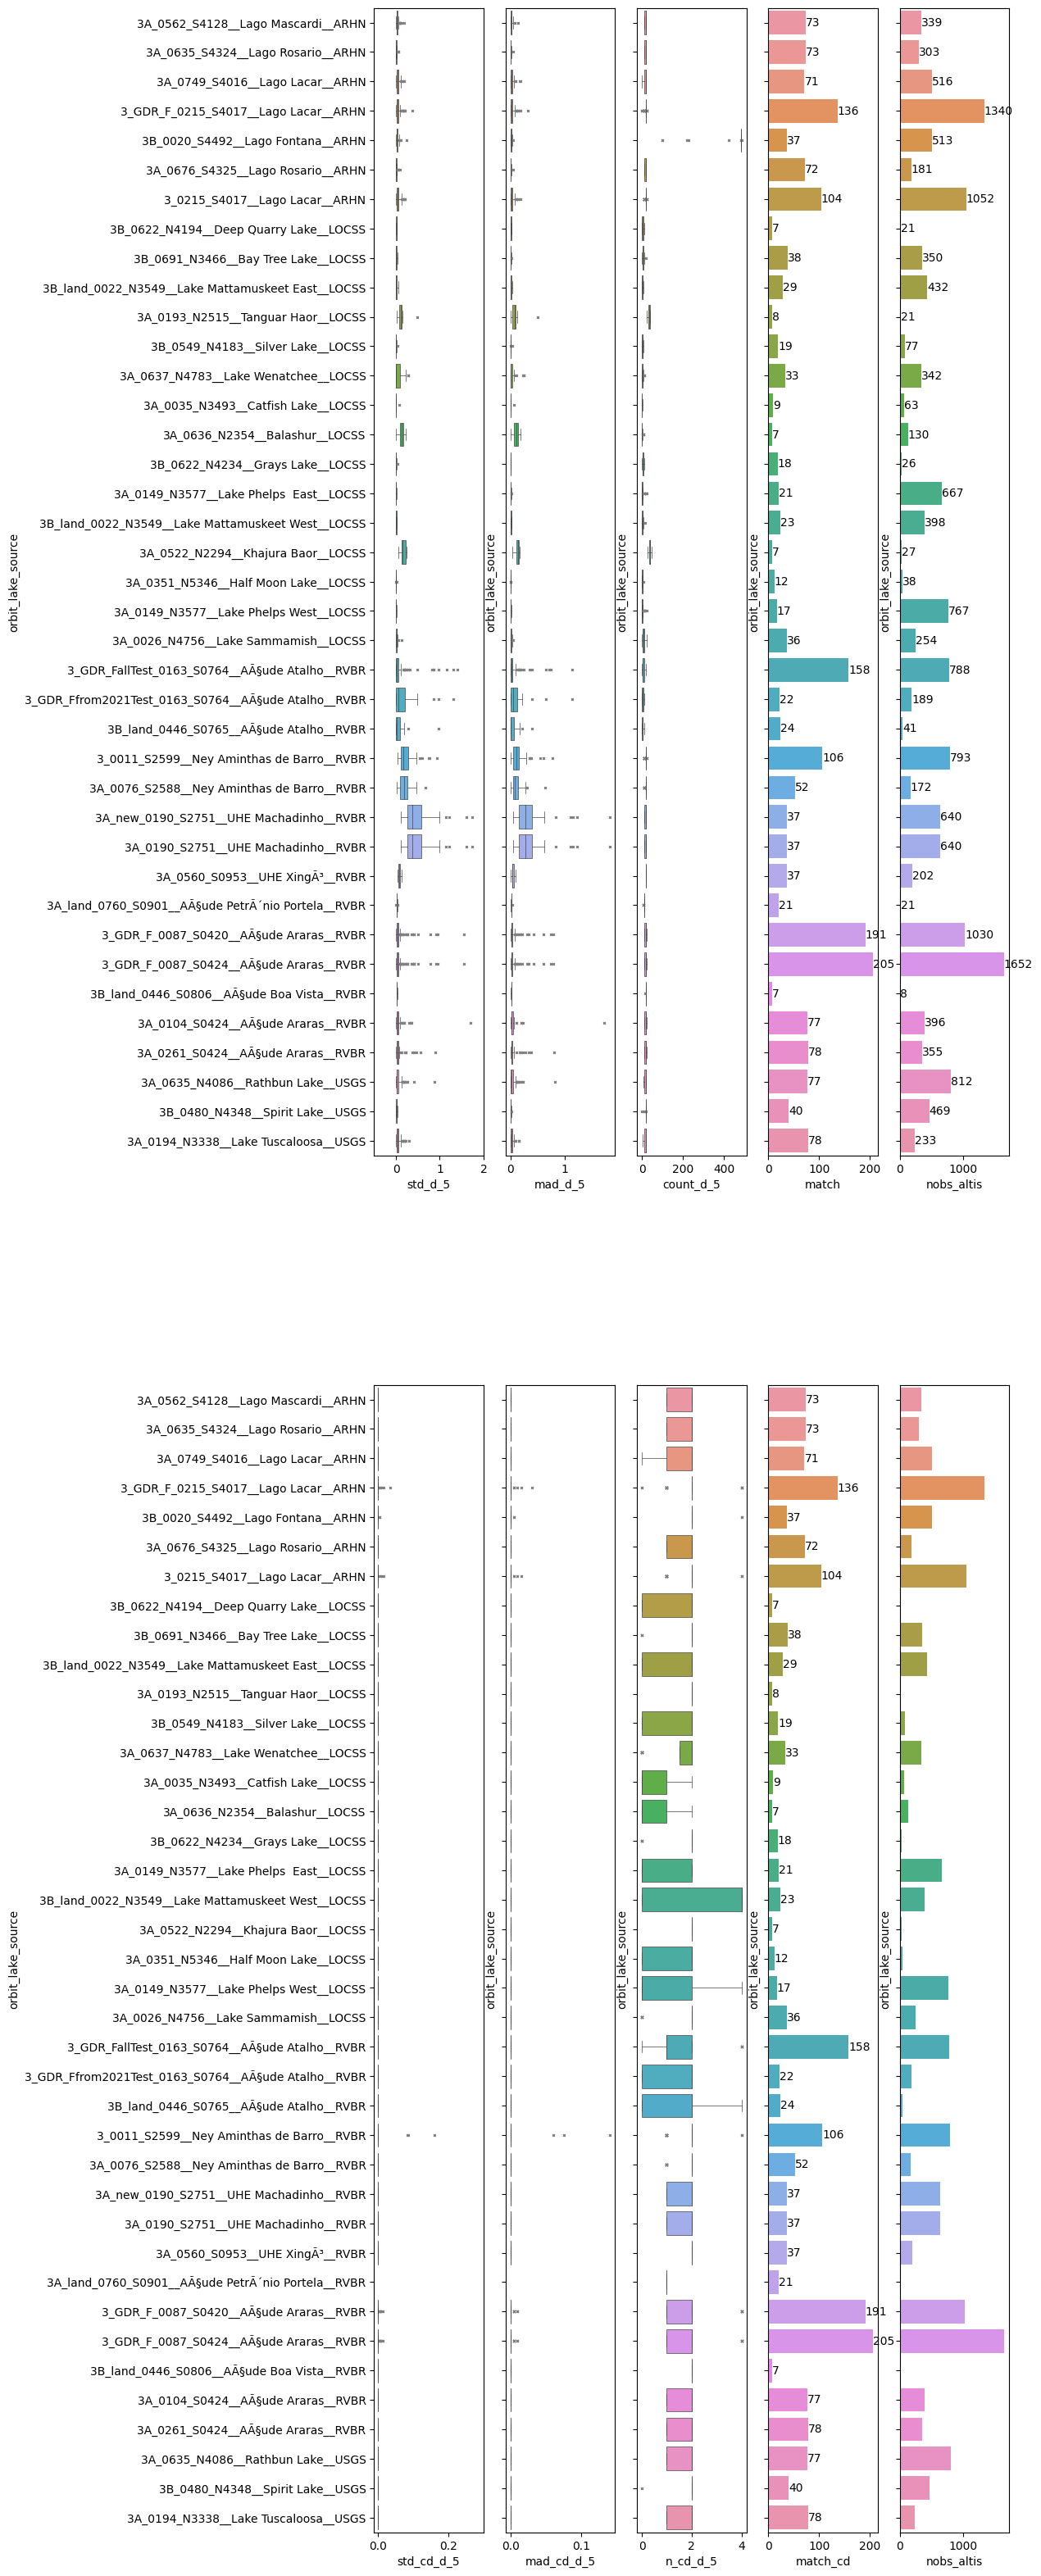

In [25]:
#Plot the results on getting the time series that match with satellite median
import seaborn as sns

names_field='name_altis'
data_field='std_d_5'

df=df_final_altis.loc[df_final_altis['for_paper']=='Y'].copy()


df['orbit_lake_source']=[x.split('-')[1] for x in df[names_field]]
df['orbit_lake_source']=df['orbit_lake_source']+'__'+df['lake_name']+'__'+df['source']
df.sort_values(by=['source'], inplace=True, ascending=True)


names_field='orbit_lake_source'
y_order=df[names_field].unique()

flierprops = dict(marker='x', markerfacecolor='None', markersize=2,  markeredgecolor='gray')

fig, axes = plt.subplots(2, 5, figsize=(10, 40), sharey=True)

#Median among values within the window
g=sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[0,0],linewidth=0.5, flierprops=flierprops, order=y_order)
axes[0,0].set_xlim(-0.5, 2)

# g.set_xticklabels(g.get_xticklabels(),rotation=90)
data_field='std_cd_d_5'
g= sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[1,0],linewidth=0.5, flierprops=flierprops, order=y_order)
axes[1,0].set_xlim(-0.01, .3)
# g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Closest value within the window
data_field='mad_d_5'
g=sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[0,1],linewidth=0.5, flierprops=flierprops, order=y_order)
axes[0,0].set_xlim(-0.5, 2)
# g.set_xticklabels(g.get_xticklabels(),rotation=90)
data_field='mad_cd_d_5'
g= sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[1,1],linewidth=0.5, flierprops=flierprops, order=y_order)
axes[1,0].set_xlim(-0.01, .3)
# g.set_xticklabels(g.get_xticklabels(), rotation=90)

data_field='count_d_5'
g=sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[0,2],linewidth=0.5, flierprops=flierprops, order=y_order)
# axes[0].set_xlim(-0.5, 2)
# g.set_xticklabels(g.get_xticklabels(),rotation=90)
data_field='n_cd_d_5'
g= sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[1,2],linewidth=0.5, flierprops=flierprops, order=y_order)
# axes[1].set_xlim(-0.01, .3)

df['match']=df[['height', 'median_d_5']].count(axis=1)
df.loc[df['match']==1, 'match']=np.nan
df.loc[df['match']==2, 'match']=1
df_count_obs=df[[names_field, 'match']].groupby(names_field).count().reset_index()

g=sns.barplot(data=df_count_obs,x='match',y=names_field, ax=axes[0,3], order=y_order)
for i in g.containers:
    g.bar_label(i,)

df['match_cd']=df[['height', 'val_cd_d_5']].count(axis=1)
df.loc[df['match_cd']==1, 'match_cd']=np.nan
df.loc[df['match_cd']==2, 'match_cd']=1
df_count_obs_cd=df[[names_field, 'match_cd']].groupby(names_field).count().reset_index()

g=sns.barplot(data=df_count_obs_cd,x='match_cd',y=names_field, ax=axes[1,3], order=y_order)    
for i in g.containers:
    g.bar_label(i,)


field='nobs_altis'
df_count_obs=df[[names_field, field]].groupby(names_field).sum().reset_index()

g=sns.barplot(data=df_count_obs,x=field,y=names_field, ax=axes[1,4], order=y_order)    
g=sns.barplot(data=df_count_obs,x=field,y=names_field, ax=axes[0,4], order=y_order)    
for i in g.containers:
     g.bar_label(i,)


 #std  standard deviation
#mad median absolute deviation


# 6. Generate the matching time series of ground and altimeter observations

In [26]:
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
df_final_ground.to_csv('../data/results/preprossed_ground_data_'+time_fig+'.csv', sep=',')
df_final_altis.to_csv('../data/results/preprossed_altis_data_'+time_fig+'.csv', sep=',')

In [27]:
time_fig

'20230503_12_15'